In [23]:
import cv2
import torch
from torch.autograd import Variable
from torch.autograd import Function
from torchvision import models
from torchvision import utils
import sys
import numpy as np

class FeatureExtractor():
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """
    def __init__(self, model, target_layers):
        self.model = model
        self.feature_extractor = FeatureExtractor(self.model.features, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations, output  = self.feature_extractor(x)
        output = output.view(output.size(0), -1)
        output = self.model.classifier(output)
        return target_activations, output

def preprocess_image(img):
    means=[0.485, 0.456, 0.406]
    stds=[0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[: , :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = Variable(preprocessed_img, requires_grad = True)
    return input

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    cv2.imwrite("cam.jpg", np.uint8(255 * cam))

class GradCam:
    def __init__(self, model, target_layer_names, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, target_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index = None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            #index = np.argmax(output.cpu().data.numpy())
            _, index = output.topk(3, 1, True, True)
            index = index.data.numpy()
        one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
        for i in index:
            one_hot[0][i] = 1
        one_hot = Variable(torch.from_numpy(one_hot), requires_grad = True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        one_hot.backward(retain_variables=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis = (2, 3))[0, :]
        cam = np.ones(target.shape[1 : ], dtype = np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

class GuidedBackpropReLU(Function):
    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = torch.addcmul(torch.zeros(input.size()).type_as(input), input, positive_mask)
        self.save_for_backward(input, output)
        return output

    def backward(self, grad_output):
        input, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input.size()).type_as(input), torch.addcmul(torch.zeros(input.size()).type_as(input), grad_output, positive_mask_1), positive_mask_2)

        return grad_input

class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        # replace ReLU with GuidedBackpropReLU
        for idx, module in self.model.features._modules.items():
            if module.__class__.__name__ == 'ReLU':
                self.model.features._modules[idx] = GuidedBackpropReLU()

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index = None):
        if self.cuda:
            output = self.forward(input.cuda())
        else:
            output = self.forward(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
        one_hot[0][index] = 1
                #one_hot[0][index] = 1
        one_hot = Variable(torch.from_numpy(one_hot), requires_grad = True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        # self.model.features.zero_grad()
        # self.model.classifier.zero_grad()
        one_hot.backward(retain_variables=True)

        output = input.grad.cpu().data.numpy()
        output = output[0,:,:,:]

        return output

In [22]:
import torch.nn as nn
vgg = models.vgg19(pretrained=True)
ls = list(vgg.children())
ft = list(ls[0].children())
ft[-1] = nn.AdaptiveMaxPool2d((7, 7))
fc = list(ls[1].children())
fc[-1] = nn.Linear(4096, 21)
ft = nn.Sequential(*ft)
fc = nn.Sequential(*fc)
class VGG(nn.Module):
    def __init__(self, features, classifier):
        super(VGG, self).__init__()
        self.features = features
        #self.roi = nn.AdaptiveMaxPool2d((7, 7))
        self.classifier = classifier

    def forward(self, x):
        x = self.features(x)
        #x = self.roi(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
model = torch.load('vgg_roi_class_net.pth').cpu()
grad_cam = GradCam(model, target_layer_names = ["35"], use_cuda=False)

img = cv2.imread('2007_000323.jpg', 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
input = preprocess_image(img)
target_index = None
mask = grad_cam(input, target_index)
show_cam_on_image(img, mask)

gb_model = GuidedBackpropReLUModel(model, use_cuda=False)
gb = gb_model(input, index=target_index)
utils.save_image(torch.from_numpy(gb), 'gb.jpg')

cam_mask = np.zeros(gb.shape)
for i in range(0, gb.shape[0]):
    cam_mask[i, :, :] = mask

cam_gb = np.multiply(cam_mask, gb)
utils.save_image(torch.from_numpy(cam_gb), 'cam_gb.jpg')

TypeError: only integer scalar arrays can be converted to a scalar index

In [20]:
import cv2
import io
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import models, transforms, datasets
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import json
import matplotlib.image as mpimg
import pandas as pd
import matplotlib.pyplot as plt
import collections
import re
def Str2np(target):
    num = re.sub(r'\D', " ", target)
    a = np.fromstring(num, dtype=int, sep=' ')
    return a

def ReadData(csv_dir, img_dir, image_sets , test = None):
    imgs = []
    if test is not None:
        train_filename = csv_dir+'/val.csv'
    else:
        train_filename = csv_dir + '/train.csv'

    data = pd.read_csv(train_filename)
    name = data.fname.values
    child = data.child.values
    for i, entry in enumerate(name):
        pack = child[i]
        imgs.append([entry, Str2np(pack)])
    return imgs

root_dir =  '/home/minty/dataset/VOCdevkit/VOC2012/'
csv_dir = os.path.join(root_dir,'src')
img_dir = os.path.join(root_dir,'JPEGImages')
image_sets =  ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',\
      'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', \
      'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
imgs = ReadData(csv_dir,img_dir,image_sets, test = None)
test_imgs = ReadData(csv_dir,img_dir,image_sets, test = True)
input_transform = transforms.Compose([
    transforms.Scale((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                        std = [ 0.229, 0.224, 0.225 ]),
])

class Data(data.Dataset):
    def __init__(self, imgs, image_sets, input_transform = None, \
                 target_transform = None ,test = None):
        self.test = test
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.classes = len(image_sets)
        self.imgs = imgs

    def __getitem__(self, index):
        fn, pack = self.imgs[index]
        #label = torch.LongTensor([[y]])
        label = self.get_label(pack)
        img = Image.open(img_dir + '/' +fn).convert('RGB')
        #box = torch.LongTensor([[xmin, ymin, xmax, ymax]])
        if self.input_transform is not None:
            img = self.input_transform(img)
        return img, pack, label,  fn
    
    def get_label(self, pack):
        num = int(pack.shape[0] / 5)
        cls = np.zeros(num)
        label = torch.zeros(self.classes)
        for j in xrange(num):
            cls[j] = pack[5*j + 4]
            label[cls[j]] = 1
        return label

    def __len__(self):
        return len(self.imgs)

img_data = Data(imgs, image_sets,  input_transform = input_transform, target_transform=None\
                , test=None)
test_data = Data(test_imgs, image_sets,  input_transform = input_transform, target_transform=None\
                , test=None)
print(len(img_data.imgs))
img_batch = data.DataLoader(img_data, batch_size=1 ,shuffle=True, num_workers = 2)
test_batch = data.DataLoader(test_data, batch_size=1 ,shuffle=True, num_workers = 2)

5717


In [3]:

class VGG(nn.Module):
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.roi = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(25088,21)

    def forward(self, x):
        x = self.features(x)
        x = self.roi(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
net = torch.load('vgg_roi_class_net2.pth')
finalconv_name = 'roi'
#net = models.resnet18(pretrained = True)
#finalconv_name = 'layer4'
net.eval()

# hook the feature extractor
features_blobs = []

def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
#hook the feature map of final conv layer
net._modules.get(finalconv_name).register_forward_hook(hook_feature) 

# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].cpu().data.numpy())  #shape: 1000,512

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [7]:
img, pack, label, fn = next(iter(img_batch))
output = net(Variable(img).cuda())
_, pred = output.topk(5, 1, True, True)
print pred

Variable containing:
  7  16   4   6   3
[torch.cuda.LongTensor of size 1x5 (GPU 0)]



In [5]:
LABELS = json.load(open('/home/minty/code/CAM/labels.json','r'))
classes = {int(key):value for (key, value)
          in LABELS.items()}
#res = models.resnet18(pretrained=True)

model predict: 0.522 -> cow, ground_truth: cow
model predict: 0.478 -> horse, ground_truth: cow


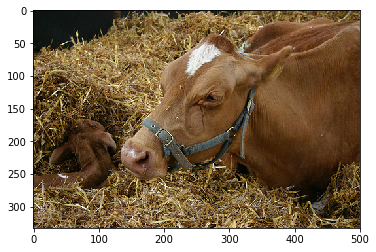

In [11]:
#------test for the model---------_#
img, pack, label, fn = next(iter(img_batch))
num = int(pack.size(1) / 5)
ground_truth = torch.FloatTensor(num, 4)
cls = torch.LongTensor(num)
pack = pack.squeeze(0)
for j in xrange(num):
    ground_truth[j] = pack[5*j: 5*j+4].clone()
    cls[j] = pack[5*j+4]
#output = net.forward(Variable(img).cuda())
#score, idx = output.topk(num, 1, True, True)
logit = net(Variable(img).cuda())
h_x = F.softmax(logit).data.squeeze()
probs, idx1 = h_x.sort(0, True)
#score = score.squeeze(0).cpu().data.numpy()
#idx = idx.squeeze(0).cpu().data.numpy()
# output the top 5 prediction
for i in range(0, num):
    #print('vgg predict: {:.3f} -> {}, ground_truth: {}'.format(score[i], image_sets[idx[i]], image_sets[cls[i]]))
    print('model predict: {:.3f} -> {}, ground_truth: {}'.format(probs[i], image_sets[idx1[i]], image_sets[cls[i]]))
img_e = Image.open(img_dir + '/' + fn[0])
plt.imshow(img_e)
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in divide


output CAM.jpg for the top1 prediction: cow


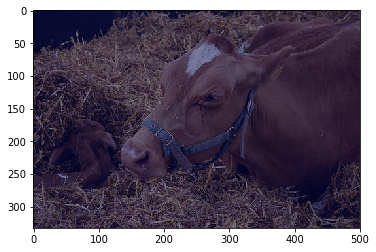

In [12]:
# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx1[0]])
# render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%image_sets[idx1[0]])
img = cv2.imread(img_dir + '/' + fn[0])
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM.jpg', result)
img = Image.open('CAM.jpg')
plt.imshow(img)
plt.show()

In [29]:
print features_blobs[0].shape, weight_softmax.shape

(1, 512, 7, 7) (21, 25088)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision import models, datasets, transforms
from torch.autograd import Variable
import numpy as np
import os
from PIL import Image
import matplotlib.image as mpimg
import pandas as pd
import matplotlib.pyplot as plt
import collections
from PIL import ImageDraw 
import random
import re
from IoU import *
from ram import ReplayBuffer
from Network import QNetwork, BboxReg, ClsNetwork

#----------------read data-----------------------
def Str2np(target):
    num = re.sub(r'\D', " ", target)
    a = np.fromstring(num, dtype=int, sep=' ')
    return a

def ReadData(csv_dir, img_dir, image_sets , test = None):
    imgs = []
    if test is not None:
        train_filename = csv_dir+'/val.csv'
    else:
        train_filename = csv_dir + '/train.csv'

    data = pd.read_csv(train_filename)
    name = data.fname.values
    child = data.child.values
    for i, entry in enumerate(name):
        pack = child[i]
        imgs.append([entry, Str2np(pack)])
    return imgs

root_dir =  '/home/minty/dataset/VOCdevkit/VOC2012/'
csv_dir = os.path.join(root_dir,'src')
img_dir = os.path.join(root_dir,'JPEGImages')
image_sets =  ['background','aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',\
      'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', \
      'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
imgs = ReadData(csv_dir,img_dir,image_sets, test = None)
test_imgs = ReadData(csv_dir,img_dir,image_sets, test = True)
input_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                        std = [ 0.229, 0.224, 0.225 ]),
])

class Data(data.Dataset):
    def __init__(self, imgs, image_sets, input_transform = None, \
                 target_transform = None ,test = None):
        self.test = test
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.classes = len(image_sets)
        self.imgs = imgs

    def __getitem__(self, index):
        fn, pack = self.imgs[index]
        #label = torch.LongTensor([[y]])
        img = Image.open(img_dir + '/' +fn).convert('RGB')
        #box = torch.LongTensor([[xmin, ymin, xmax, ymax]])
        if self.input_transform is not None:
            img = self.input_transform(img)
        return img, pack, fn

    def __len__(self):
        return len(self.imgs)

img_data = Data(imgs, image_sets,  input_transform = input_transform, target_transform=None\
                , test=None)
test_data = Data(test_imgs, image_sets,  input_transform = input_transform, target_transform=None\
                , test=None)
print(len(img_data.imgs))
img_batch = data.DataLoader(img_data, batch_size=1 ,shuffle=True, num_workers = 2)
test_batch = data.DataLoader(test_data, batch_size=1 ,shuffle=True, num_workers = 2)

5717


In [5]:
#---------hyper parameters---------#
class_object = 1
scale_subregion = float(5)/6
translate = 0.25
number_of_steps = 10
epochs = 50
gamma = 0.90
epsilon = 1
buffer_size = 10000
num_his = 4
#translation_dim = 5
#scaling_dim = 8
action_dim = 6
state_dim = action_dim * num_his + 2048
critic_lr = 0.001
actor_lr = 0.01
tau = 0.001
random_seed = 1234
max_step = 10
iou_threshold = 0.5
minibatch_size = 64
#---------Net-----------#
#resnet = torch.load('res_roi_net.pth')
#resnet = models.resnet18(pretrained = True)
#Extractor = nn.Sequential(*list(resnet.children())[:-2]).cuda()
#vgg = models.vgg19(pretrained = True).features
#print vgg
ls = list(vgg.children())
ft = list(ls[0].children())
ft[-1] = nn.AdaptiveMaxPool2d((7, 7))
fc = list(ls[1].children())
fc[-1] = nn.Linear(4096, 21)
ft = nn.Sequential(*ft)
fc = nn.Sequential(*fc)
class VGG(nn.Module):
    def __init__(self, features, classifier):
        super(VGG, self).__init__()
        self.features = features
        #self.roi = nn.AdaptiveMaxPool2d((7, 7))
        self.classifier = classifier

    def forward(self, x):
        x = self.features(x)
        #x = self.roi(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
vgg = torch.load('vgg_roi_class_net.pth')
Extractor = nn.Sequential(*list(vgg.features.children())[:-5]).cuda()
replay_buffer = ReplayBuffer(buffer_size, random_seed)
loss_func = nn.MSELoss()
target = QNetwork(state_dim, action_dim).cuda()
model = QNetwork(state_dim, action_dim).cuda()
#reg = BboxReg(18432).cuda()
#optimizer = torch.optim.Adam(model.parameters(), critic_lr)
optimizer = torch.optim.SGD(model.parameters(), critic_lr, momentum = 0.9)
#optimizer_b = torch.optim.Adam(reg.parameters(), 0.001)
print "model loaded..."

model loaded...


In [7]:
img, pack, fn= next(iter(img_batch))
box_img = img[:, :, 0:17, 0:17]
#print Extractor.forward(Variable(box_img).cuda()).size()

RuntimeError: Given input size: (512x1x1). Calculated output size: (512x0x0). Output size is too small at /pytorch/torch/lib/THCUNN/generic/SpatialDilatedMaxPooling.cu:69

In [2]:
def bbox_transform_inv(boxes, deltas):
    boxes = boxes.numpy()
    deltas = deltas.data.cpu().numpy()
    
    if boxes.shape[0] == 0:
        return np.zeros((0, deltas.shape[1]), dtype=deltas.dtype)

    #boxes = boxes.astype(deltas.dtype, copy=False)
    widths, heights, ctr_x, ctr_y = _whctrs(boxes)

    dx = deltas[0]
    dy = deltas[1]
    dw = deltas[2]
    dh = deltas[3]

    pred_ctr_x = dx * widths + ctr_x
    pred_ctr_y = dy * heights + ctr_y
    pred_w = np.exp(dw) * widths
    pred_h = np.exp(dh) * heights
    #--------corresponding to coordinates-------#
    pred_boxes = np.zeros(deltas.shape, dtype=deltas.dtype)
    pred_boxes[0] = pred_ctr_x - 0.5 * pred_w
    pred_boxes[1] = pred_ctr_y - 0.5 * pred_h
    pred_boxes[2] = pred_ctr_x + 0.5 * pred_w
    pred_boxes[3] = pred_ctr_y + 0.5 * pred_h
    return pred_boxes

In [3]:
def MaskImage(gt, img):
    img[:, 0, gt[1]:gt[3]+1, gt[0]:gt[2] + 1] = torch.mean(img.squeeze(0)[0])
    img[:, 1, gt[1]:gt[3]+1, gt[0]:gt[2] + 1] = torch.mean(img.squeeze(0)[1])
    img[:, 2, gt[1]:gt[3]+1, gt[0]:gt[2] + 1] = torch.mean(img.squeeze(0)[2])
    return img

def Transition(box, feature):
    """box[0] = np.floor(box[0])
    box[1] = np.floor(box[1])
    box[2] = np.ceil(box[2])
    box[3] = np.ceil(box[3])"""
    #x_img = feature[:, :, int(box[1]):int(box[3])+1, int(box[0]):int(box[2])+1]
    x_img = feature[:, :, int(box[1]):int(box[3])+1, int(box[0]):int(box[2])+1]
    return x_img

def Clip_boxes(box, im_shape):
    #print box
    box[0] = np.maximum(np.minimum(box[0], im_shape[0] - 1), 0)
    box[1] = np.maximum(np.minimum(box[1], im_shape[1] - 1), 0)
    box[2] = np.maximum(np.minimum(box[2], im_shape[0] - 1), 0)
    box[3] = np.maximum(np.minimum(box[3], im_shape[1] - 1), 0)
    new_box = torch.FloatTensor([box[0], box[1], box[2], box[3]])
    return new_box

def GetState(box, history_vector, feature):
    box_img = Transition(box, feature)
    roi_pooling = nn.AdaptiveAvgPool2d((2, 2))
    #state1 = roi_pooling(box_img).view(-1)
    #box_img = box_img.resize_((1, 3, 224, 224))
    state1 = roi_pooling(feature).view(-1)
    #state2 = roi_pooling(Extractor.forward(Variable(img, volatile = True).cuda())).view(-1)
    #state2 = roi_pooling(feature).view(-1)
    state3 = Variable(torch.from_numpy(history_vector)).view(-1).float().cuda()
    state = torch.cat((state1, state3), 0).unsqueeze(0)
    return state

class Scaling(object):
    def __init__(self, box):
        self.xmin, self.ymin, self.xmax, self.ymax = box
        self.width, self.height, self.center_x, self.center_y = _whctrs(box)
        self.width *= scale_subregion
        self.height *= scale_subregion
        self.box = box

    def UpLeft(self):
        self.xmax = self.xmin + self.width
        self.ymax = self.ymin + self.height
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None
    
    def UpRight(self):
        self.xmin = self.xmax - self.width
        self.ymax = self.ymin + self.height
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None      
    
    def DownLeft(self):
        self.xmax = self.xmin + self.width
        self.ymin = self.ymax - self.height
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None        
    
    def DownRight(self):
        self.xmin = self.xmax - self.width
        self.ymin = self.ymax - self.height
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None       
    
    def Center(self):
        self.xmax = self.center_x + self.width / 2
        self.xmin = self.center_x - self.width / 2 
        self.ymax = self.center_y + self.height / 2
        self.ymin = self.center_y - self.height / 2
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None
    
    def Shrink(self):
        self.width /= scale_subregion
        #self.height /= scale_subregion
        self.ymin = self.center_y - self.height / 2
        self.ymax = self.center_y + self.height / 2
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None
    
    def Enlarge(self):
        #self.width /= (scale_subregion) ** 2
        self.height /= (scale_subregion) ** 2
        self.ymin = self.center_y - self.height / 2
        self.ymax = self.center_y + self.height / 2
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None
    
    def Stretch(self):
        self.width /= (scale_subregion) ** 2
        #self.height /= scale_subregion
        self.xmin = self.center_x - self.width /2
        self.xmax = self.center_x + self.width /2 
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None   
    
    def Narrow(self):
        #self.width /= scale_subregion
        self.height /= scale_subregion
        self.xmin = self.center_x - self.width /2
        self.xmax = self.center_x + self.width /2 
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None
    
    def Trigger(self):
        return self.box, True, True
    
def Generate(a, box):
    if a == 0:
        return Scaling(box).UpLeft()
    elif a == 1:
        return Scaling(box).UpRight()
    elif a == 2:
        return Scaling(box).DownLeft()
    elif a == 3:
        return Scaling(box).DownRight()
    elif a == 4:
        return Scaling(box).Center()
    else:
        return Scaling(box).Trigger()
    

In [11]:
def Sample(box, img, Trigger, masked, action, history_vector, record, Step):
    reward = 0.
    terminal = 0.
    feature_shape = np.array([feature.size(3), feature.size(2)])
    #box = Clip_boxes(box, feature_shape)
    iou, new_iou, record, ind = IoUList(Projection(box, img, feature), ground_truth, \
                                        record, available_ob, cls, class_object)
    #iou, new_iou, record, ind = IoUList(box, ground_truth, record, available_ob, cls, class_object)
    if Trigger is True:
        if new_iou > iou_threshold:
            reward += 3.0
        else:
            reward -= 3.0
    else:
        if new_iou > iou:
            reward += 1.0
        else:
            reward -= 1.0
    #-------update history vector----#
    his = np.zeros(action_dim)
    his[action] = 1
    if Step < num_his:
        history_vector[Step][action] = 1
    else:
        history_vector = np.vsplit(history_vector, np.array([1, num_his]))[1]
        history_vector = np.vstack((history_vector, his))
    
    next_state = GetState(box.squeeze(0), history_vector, feature)
        
    if masked is True:
        img = MaskImage(ground_truth[ind].long(), img)
        for k in xrange(num):
            overlap = Overlap(Projection(box, img, feature), ground_truth[k])
            #overlap = Overlap(box.squeeze(0), ground_truth[k])
            if overlap > 0.6:
                available_ob[k] = 0
    if np.count_nonzero(available_ob) == 0:
        terminal = 1.
    Step += 1
        
    return next_state, reward, img, terminal, available_ob, record, history_vector, Step

def IoUList(box, ground_truth, record, available_ob, cls, class_id):
    iou_result = np.zeros(num)
    #num_anchors = anchors.size(0)
    #p = np.zeros(num_anchors)
    for k in range(num):
        if cls[k] == class_id:
            if available_ob[k] == 1.:
                iou_result[k] = IoU(box, ground_truth[k])
            else:
                iou_result[k] = -1.
    max_iou = max(iou_result)
    ind = np.argmax(iou_result)
    return record[ind], max_iou, iou_result, ind

def CreateDict(target, net):
    new_state_dict = collections.OrderedDict()
    #critic_target.load_state_dict( (1 - tau) * critic_target.state_dict() + tau * critic.state_dict())
    keys = net.state_dict().keys()
    for item in keys:
        params1 = net.state_dict()[item]
        params2 = target.state_dict()[item]
        new_state_dict[item] = (1 - tau) * params2 + tau * params1
    return new_state_dict

def CheckGradientUpdate(target, net):
    for param, shared_param in zip(net.parameters(),
                                                           target.parameters()):
        shared_param.data.copy_ ((1.0 - tau) * shared_param.data + tau * param.data)
            
def HardUpdate(target, net):
    for param, shared_param in zip(net.parameters(),
                                                       target.parameters()):
        shared_param.data.copy_(param.data)

In [14]:
def _whctrs(anchor):
    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr

def _mkanchors(ws, hs, x_ctr, y_ctr):
    anchors = np.array((x_ctr - 0.5 * (ws - 1),
                         y_ctr - 0.5 * (hs - 1),
                         x_ctr + 0.5 * (ws - 1),
                         y_ctr + 0.5 * (hs - 1)))
    #print anchors
    return torch.from_numpy(anchors).float()

def Projection(box, img, feature):
    im_shape = np.array([0, 0, img.size(3), img.size(2)])
    im_w, im_h, im_ctrx, im_ctry = _whctrs(im_shape)
    feature_shape = np.array([0, 0, feature.size(3), feature.size(2)])
    f_w, f_h, f_ctrx, f_ctry = _whctrs(feature_shape)
    w, h, ctrx, ctry = _whctrs(box_.squeeze(0))
    scale_x = float(im_w) / float(f_w)
    scale_y = float(im_h) / float(f_h)
    dx = (ctrx - f_ctrx) * scale_x
    dy = (ctry - f_ctry) * scale_y
    ctrx = dx + im_ctrx 
    ctry = dy + im_ctry
    gt = _mkanchors(w * scale_x, h * scale_y, ctrx, ctry)
    return gt

def Projection_inv(gt, img):
    im_shape = np.array([0, 0, img.size(3), img.size(2)])
    _, _, im_ctrx, im_ctry = _whctrs(im_shape)
    feature_shape = np.array([0, 0, feature.size(3), feature.size(2)])
    _, _, f_ctrx, f_ctry = _whctrs(feature_shape)
    w, h, ctrx, ctry = _whctrs(gt)
    dx = (ctrx - im_ctrx) / 16
    dy = (ctry - im_ctry) / 16
    ctrx = dx + f_ctrx 
    ctry = dy + f_ctry
    gt = _mkanchors(w / 16, h / 16, ctrx, ctry)
    return gt

def bbox_transform(ex_rois, gt_rois):
    ex_rois = ex_rois.numpy()
    ex_widths, ex_heights, ex_ctr_x, ex_ctr_y = _whctrs(ex_rois)
    
    gt_rois = gt_rois.numpy()
    gt_widths, gt_heights, gt_ctr_x, gt_ctr_y = _whctrs(gt_rois)

    targets_dx = (gt_ctr_x - ex_ctr_x) / ex_widths
    targets_dy = (gt_ctr_y - ex_ctr_y) / ex_heights
    targets_dw = np.log(gt_widths / ex_widths)
    targets_dh = np.log(gt_heights / ex_heights)

    targets = np.vstack(
        (targets_dx, targets_dy, targets_dw, targets_dh)).transpose()

    return targets

In [15]:
loss_his = []
roi_pooling = nn.AdaptiveAvgPool2d((6, 6))
for i in range(epochs):
    for step, (img, pack, fn) in enumerate(img_batch):
        num = int(pack.size(1) / 5)
        #----parameters initializing-----------#
        masked = None
        terminal = 0.
        available_ob = np.ones(num)
        ground_truth = torch.FloatTensor(num, 4)
        cls = torch.LongTensor(num)
        pack = pack.squeeze(0)
        im_shape = np.array([img.size(3), img.size(2)])
        feature = Extractor.forward(Variable(img).cuda())
        #-----record the gt and cls------#
        for j in xrange(num):
            ground_truth[j] = pack[5*j: 5*j+4].clone()
            cls[j] = pack[5*j+4]
        #--------for every object---------#
        for j in xrange(num):
            if cls[j] == class_object:
                Step = 0
                history_vector = np.zeros((num_his, action_dim))               
                box_ = torch.FloatTensor([0, 0, feature.size(3), feature.size(2)]) #Initial box_
                s = GetState(box_, history_vector, feature)
                record = np.zeros(num)
                Trigger = None
                box_1 = Projection(box_.squeeze(0), img, feature)
                iou, new_iou, record, ind = IoUList(box_1, ground_truth, record, available_ob, cls, class_object)
                learn_step = 0
                while(Trigger is None and Step < max_step and terminal == 0.):
                    #-----get action------#
                    if i < 100 and new_iou > 0.5:
                        action = 5
                        print "first move triggered, reaching iou: ", new_iou
                    elif random.random() < epsilon:
                        action = np.random.randint(0, 6)
                    else:
                        output = model.forward(s)
                        action = torch.max(output.data, 1)[1].cpu().numpy()[0]
                    #-------------#sample the action------#
                    print action
                    box, Trigger, masked = Generate(action, box_.squeeze(0))
                    s2, r, img, terminal, available_ob, record, history_vector, Step = Sample(box.squeeze(0), \
                                                                        img, Trigger, \
                                                                masked, action, history_vector, record, Step)
                    replay_buffer.add(s, action, r , terminal, s2)
                    #feature = Extractor.forward(Variable(img).cuda())  #extract feature with new masked image
                    #---------train Q network-------#
                    if replay_buffer.size() > minibatch_size:
                        s_batch, a_batch, r_batch, t_batch, s2_batch = replay_buffer.sample_batch(minibatch_size)
                        s_batch = Variable(torch.from_numpy(s_batch)).cuda()
                        a_batch = Variable(torch.from_numpy(a_batch)).cuda()
                        s2_batch = Variable(torch.from_numpy(s2_batch)).cuda()
                        r_batch = Variable(torch.from_numpy(r_batch)).float().cuda()
                        t_batch = Variable(torch.from_numpy(t_batch)).float().cuda()
                        
                        if learn_step % 10 == 0:
                            target.load_state_dict(model.state_dict())
                        learn_step += 1

                        q_eval = model(s_batch).squeeze(1).gather(1, a_batch.unsqueeze(1))
                        q_next = target(s2_batch).squeeze(1).detach()
                        q_target = r_batch + (1 - t_batch) * gamma * q_next.max(1)[0]
                        q_target = torch.autograd.Variable(q_target.data)
                        loss = loss_func(q_eval, q_target)
                        optimizer.zero_grad()
                        loss.backward(retain_graph = True)
                        optimizer.step()

                    #-------update state and box---#
                    box_ = box.clone()
                    s = s2
                available_ob[ind] = 0
        if epsilon > 0.1:
            epsilon -= 0.1
        else:
            epsilon = 0.1

    loss_his.append(loss.data[0])
    print('epoch: {}, loss: {}'.format(i, loss.data[0]))
    if i > 0 and i % 10 == 0:
        torch.save(model, 'featurevggmodel'+str(i / 10)+'.pth')
        torch.save(target, 'featurevggtarget'+str(i / 10)+'.pth')
        #torch.save(reg, 'newreg' + str(i / 10) + '.pth')

first move triggered, reaching iou:  0.626372372372
5
first move triggered, reaching iou:  0.849152
5
first move triggered, reaching iou:  0.522162162162
5
first move triggered, reaching iou:  0.547317073171
5
4
0
4
0
1
4
3
4
0
0
1
4
4
3
4
4
3
2
0
4
4
3
1
0
3
1
0
4
1
4
1
3
0
3
1
1
5
3
1
4
0
0
0
1
0
4
4
3
3
3
4
0
3
4
4
4
4
3
first move triggered, reaching iou:  0.887111111111
5
first move triggered, reaching iou:  0.684170666667
5
4
4
1
4
4
4
5
0
5
5
5
first move triggered, reaching iou:  0.563650485437
5
5
5
5
5
first move triggered, reaching iou:  0.995081871345
5
first move triggered, reaching iou:  0.763392
5
3
5
3
1
1
1
1
1
1
1
1
3
0
1
4
1
1
1
0
4
4
4
4
4
4
4
0
0
0
0
2
0
3
1
1
2
2
1
0
1
4
1
1
0
1
1
1
1
1
1
1
1
3
3
4
2
4
1
4
1
1
1
4
4
1
1
4
4
1
4
1
1
4
1
4
4
4
4
4
5
4
4
1
4
4
1
1
4
4
1
4
first move triggered, reaching iou:  0.562012012012
5
first move triggered, reaching iou:  0.809657657658
5
4
4
4
1
1
1
1
4
0
4
0
1
4
2
2
1
1
0
3
1
first move triggered, reaching iou:  0.72122133333

3
4
2
4
4
4
1
4
4
4
2
0
2
0
3
0
5
3
5
2
1
2
2
2
0
1
2
2
1
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
1
4
1
1
0
4
1
2
0
1
4
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
0
0
3
0
0
3
3
0
2
3
0
3
0
0
0
3
0
1
0
4
first move triggered, reaching iou:  0.746790419162
5
1
3
3
3
1
3
3
3
3
3
3
3
4
3
3
3
3
4
4
3
4
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.951456
5
first move triggered, reaching iou:  0.87824
5
first move triggered, reaching iou:  0.533513513514
5
first move triggered, reaching iou:  0.647447447447
5
0
0
0
0
0
0
0
0
0
0
first move triggered, reaching iou:  0.604024024024
5
4
2
4
4
4
2
2
4
2
4
first move triggered, reaching iou:  0.983370666667
5
3
3
3
3
3
3
3
3
3
3
first move triggered, reaching iou:  0.566642642643
5
first move triggered, reaching iou:  0.792
5
3
2
3
3
3
3
3
3
3
0
3
0
3
0
2
0
0
0
2
2
5
first move triggered, reaching iou:  0.521081081081
5
2
2
2
4
2
2
2
2
2
2
5
0
0
0
0
0
0
0
0
0
0
4
4
4
4
4
4
4
2
4
4
5
4
1
4
3
4
0
2
4
4
4
2
2
2
5
3
3
0
3
3
3
2
3
3
3
first move

1
1
1
1
1
1
1
1
1
1
1
1
0
1
3
1
1
1
1
1
1
1
1
3
1
1
1
3
1
1
1
1
5
1
2
2
2
2
3
1
2
2
2
2
2
2
2
2
2
0
0
2
2
3
3
3
4
4
2
2
2
3
1
0
0
0
0
0
0
0
0
0
4
2
2
5
first move triggered, reaching iou:  0.561222707424
5
3
2
0
3
3
5
5
4
3
4
4
4
0
4
4
4
4
3
0
3
3
3
4
3
3
1
0
0
2
2
0
2
2
2
3
4
4
2
2
2
2
4
4
4
4
2
4
first move triggered, reaching iou:  0.722350148368
5
2
2
2
4
2
2
2
2
2
2
first move triggered, reaching iou:  0.596933333333
5
0
3
0
0
0
3
5
0
3
3
4
5
3
3
3
3
3
3
3
4
3
3
3
3
3
3
3
3
3
3
3
2
3
3
3
3
3
3
3
3
0
3
first move triggered, reaching iou:  0.502203592814
5
5
first move triggered, reaching iou:  0.809657657658
5
4
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.522162162162
5
4
3
3
0
3
3
0
1
0
3
3
3
0
0
4
3
3
4
4
3
5
first move triggered, reaching iou:  0.512348348348
5
4
4
4
4
4
4
4
4
4
4
2
2
5
2
2
2
2
2
1
2
2
2
2
5
first move triggered, reaching iou:  0.69368
5
2
2
2
2
2
2
2
2
1
2
first move triggered, reaching iou:  0.811706666667
5
1
1
2
4
2
4
5
1
1
2
1
1
1
1
2
2
2
5
0
5

1
1
1
1
1
5
4
4
4
4
4
3
4
4
4
4
3
3
1
3
0
0
2
0
3
0
2
0
2
0
0
1
0
0
3
2
2
2
1
0
2
0
2
0
0
0
first move triggered, reaching iou:  0.763392
5
0
0
5
2
0
4
4
4
4
4
4
4
4
4
4
4
2
2
4
2
4
4
4
4
4
1
4
4
4
0
4
4
5
first move triggered, reaching iou:  0.886475644699
5
4
4
2
0
1
0
4
4
0
2
4
1
2
1
4
1
1
1
3
5
0
0
0
0
0
0
0
1
0
0
4
4
4
4
4
4
4
4
4
1
3
3
1
4
3
3
1
4
1
3
first move triggered, reaching iou:  0.710576
5
2
4
4
5
5
1
1
3
3
3
1
2
3
4
0
first move triggered, reaching iou:  0.983370666667
5
1
3
3
2
3
3
2
2
2
2
2
2
2
1
2
2
2
2
2
2
5
first move triggered, reaching iou:  0.721221333333
5
first move triggered, reaching iou:  0.950191616766
5
4
4
4
4
4
1
1
4
1
4
4
4
1
4
4
4
1
4
1
4
first move triggered, reaching iou:  0.533513513514
5
first move triggered, reaching iou:  0.596933333333
5
4
4
4
4
4
4
4
4
4
4
0
0
0
0
0
5
5
0
0
5
5
4
0
4
4
4
4
4
4
4
4
5
first move triggered, reaching iou:  0.50752
5
first move triggered, reaching iou:  0.61954494382
5
2
2
4
2
2
2
0
0
4
0
first move triggered, reac

4
4
4
4
1
1
4
4
1
2
4
1
4
4
1
4
1
0
2
4
2
1
2
2
1
2
1
2
3
2
first move triggered, reaching iou:  0.684170666667
5
first move triggered, reaching iou:  0.647447447447
5
2
4
0
4
4
4
2
4
4
2
0
4
4
0
0
4
0
0
1
0
4
4
4
4
4
1
4
4
4
4
1
1
1
1
1
0
1
1
1
1
1
4
1
1
1
1
1
3
0
1
4
1
1
0
0
1
1
4
0
1
0
1
0
0
1
1
1
1
0
1
4
4
4
1
4
4
3
1
4
4
first move triggered, reaching iou:  0.87824
5
2
2
2
2
0
5
1
1
5
first move triggered, reaching iou:  0.955915662651
5
4
4
4
4
1
4
1
1
4
4
0
0
0
0
0
0
0
0
0
0
first move triggered, reaching iou:  0.563744
5
0
0
0
2
0
2
2
4
0
5
first move triggered, reaching iou:  0.506528528529
5
first move triggered, reaching iou:  0.534928
5
4
4
4
2
2
2
4
2
2
2
2
4
4
2
4
2
2
2
4
2
2
2
1
2
2
0
1
3
2
2
1
4
1
4
0
0
4
3
1
5
2
0
4
2
0
2
0
2
2
2
2
4
2
4
2
2
3
2
2
3
2
2
2
2
2
2
0
3
2
3
first move triggered, reaching iou:  0.538734939759
5
first move triggered, reaching iou:  0.520416
5
first move triggered, reaching iou:  0.887111111111
5
2
2
2
2
1
1
2
2
5
2
1
1
1
1
4
1
0
1
4
1
1
2
2
1

4
4
4
4
4
0
0
4
4
4
first move triggered, reaching iou:  0.5988
5
epoch: 3, loss: 0.796003103256
4
4
4
2
2
2
3
4
2
4
4
4
4
3
4
4
2
4
3
4
4
4
4
4
2
3
3
3
1
4
first move triggered, reaching iou:  0.75824024024
5
2
0
3
5
first move triggered, reaching iou:  0.721221333333
5
4
4
4
4
4
0
4
3
4
0
4
4
4
4
4
4
4
2
4
4
0
0
2
0
2
0
2
2
2
2
2
0
5
first move triggered, reaching iou:  0.684170666667
5
first move triggered, reaching iou:  0.865734939759
5
first move triggered, reaching iou:  0.849152
5
4
4
4
4
0
4
0
1
4
4
3
4
3
3
3
0
3
3
3
3
3
5
0
0
0
1
0
0
0
0
0
0
4
1
4
2
5
4
4
4
2
3
4
4
4
4
5
first move triggered, reaching iou:  0.811706666667
5
4
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.746790419162
5
first move triggered, reaching iou:  0.652423880597
5
first move triggered, reaching iou:  0.925345345345
5
first move triggered, reaching iou:  0.825013333333
5
first move triggered, reaching iou:  0.532084084084
5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
4
3
0
0
0
0
0
3
0
0
0
0
0


first move triggered, reaching iou:  0.935183183183
5
4
4
1
4
4
4
4
4
4
4
1
1
1
3
1
2
1
2
1
1
4
2
4
4
4
4
4
4
4
4
4
3
4
3
4
3
3
3
3
3
3
4
3
3
3
4
3
4
1
3
5
4
2
2
2
4
4
2
4
4
4
4
2
2
4
4
4
4
2
2
2
3
3
4
3
3
3
3
3
3
3
3
4
3
3
3
3
3
4
3
0
0
0
0
0
4
4
4
0
4
4
4
4
4
4
4
4
2
4
4
4
1
1
4
5
1
1
1
4
4
1
5
4
4
4
4
4
4
4
3
4
4
first move triggered, reaching iou:  0.658666666667
5
4
4
4
3
4
4
4
4
4
4
4
3
3
4
5
4
3
4
3
3
4
4
4
3
2
5
3
4
4
1
4
4
1
4
4
1
0
2
0
1
1
1
2
3
3
1
3
1
3
1
1
1
3
3
3
2
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
4
4
2
4
4
4
4
4
4
4
4
3
4
3
3
3
3
3
3
3
3
3
1
3
3
3
2
2
3
4
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
1
2
4
4
4
4
4
4
4
4
4
4
3
3
3
4
3
3
0
3
3
3
3
3
3
3
3
3
3
3
1
3
3
3
5
3
5
3
2
4
4
4
4
4
4
4
4
4
1
1
1
1
0
1
1
0
1
2
first move triggered, reaching iou:  0.932459701493
5
0
4
4
4
4
4
4
4
4
4
0
4
4
4
5
4
4
4
4
4
4
3
4
4
4
first move triggered, reaching iou:  0.785213213213
5
first move triggered, reaching iou:  0.769868263473
5
1
1
1
1
1
1
1
3
5
1
1
3
1
4
1
3
0
1
1
first move t

4
4
4
4
4
4
4
4
4
4
3
0
0
3
1
3
0
3
1
3
first move triggered, reaching iou:  0.747588932806
5
4
4
4
4
5
first move triggered, reaching iou:  0.671952095808
5
first move triggered, reaching iou:  0.604024024024
5
first move triggered, reaching iou:  0.840608
5
4
4
4
1
4
1
3
1
1
3
4
1
4
1
1
1
1
0
1
1
1
4
4
4
5
4
4
4
3
5
4
4
4
5
first move triggered, reaching iou:  0.953333333333
5
first move triggered, reaching iou:  0.79991641791
5
4
4
4
0
0
0
4
4
0
4
first move triggered, reaching iou:  0.50752
5
3
5
3
2
5
5
4
1
1
1
5
1
4
3
1
0
4
4
0
5
5
2
2
2
0
5
3
3
3
3
3
3
3
3
4
0
3
3
3
0
0
0
1
0
3
0
first move triggered, reaching iou:  0.935183183183
5
4
4
0
4
1
1
4
4
4
1
4
4
4
4
4
4
4
4
4
1
first move triggered, reaching iou:  0.951456
5
4
4
1
4
4
2
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
2
4
first move triggered, reaching iou:  0.925345345345
5
4
4
4
3
1
1
0
1
0
3
1
4
1
4
1
4
3
1
1
3
first move triggered, reaching iou:  0.825013333333
5
0
0
4
4
3
1
0
0
0
4
first move triggered, reaching iou: 

4
4
4
4
4
2
4
1
4
4
4
4
4
4
1
2
4
2
1
1
4
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.652423880597
5
1
0
4
1
1
1
1
4
1
1
1
0
1
4
1
4
1
5
4
4
4
3
0
4
1
3
3
0
1
4
1
1
5
1
5
first move triggered, reaching iou:  0.528144144144
5
0
4
4
1
1
5
first move triggered, reaching iou:  0.951456
5
4
4
4
4
3
4
2
4
4
4
4
4
4
4
2
4
5
first move triggered, reaching iou:  0.512348348348
5
4
4
4
4
3
3
0
4
3
5
4
5
5
first move triggered, reaching iou:  0.534928
5
0
0
3
0
0
0
0
0
0
0
4
4
4
4
4
4
1
1
1
4
first move triggered, reaching iou:  0.840608
5
4
4
1
1
1
1
1
1
1
4
first move triggered, reaching iou:  0.983370666667
5
3
4
4
4
3
2
4
4
4
3
4
4
4
4
0
4
4
4
4
0
first move triggered, reaching iou:  0.953333333333
5
0
0
0
5
first move triggered, reaching iou:  0.671952095808
5
first move triggered, reaching iou:  0.566642642643
5
4
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.811706666667
5
first move triggered, reaching iou:  0.521887323944
5
0
0
5
4
1
4
4
0
4
3
0
0
4
first move tri

4
4
4
4
4
2
4
1
3
4
first move triggered, reaching iou:  0.563744
5
4
4
4
3
4
1
4
5
4
5
4
4
4
4
1
4
4
4
4
4
4
4
5
4
3
1
0
2
3
3
4
0
4
4
4
4
4
4
4
4
4
3
1
4
4
4
3
1
1
1
3
4
5
0
0
0
5
5
first move triggered, reaching iou:  0.55831641791
5
first move triggered, reaching iou:  0.983370666667
5
4
4
4
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
1
3
4
3
0
3
3
0
3
3
0
4
0
0
0
0
0
0
4
3
0
first move triggered, reaching iou:  0.865734939759
5
1
4
0
0
0
0
0
0
4
0
4
4
4
4
3
4
4
0
4
5
1
2
0
0
1
0
1
1
0
2
0
1
4
0
0
1
0
1
0
1
3
4
0
3
3
3
0
3
3
3
2
4
2
2
2
3
3
2
5
3
3
3
2
2
3
3
4
2
3
first move triggered, reaching iou:  0.951456
5
4
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.652423880597
5
first move triggered, reaching iou:  0.726544
5
first move triggered, reaching iou:  0.563650485437
5
4
4
4
4
4
0
4
4
4
4
4
4
4
4
4
4
4
4
4
4
0
1
3
5
1
1
1
2
1
1
1
5
5
4
4
4
4
0
5
5
4
4
4
4
4
4
4
4
5
4
4
0
4
4
4
4
1
4
4
4
4
4
4
1
4
4
4
4
4
first move triggered, reaching iou:  0.669863013699
5
f

first move triggered, reaching iou:  0.619434666667
5
4
4
2
0
4
4
2
2
4
5
1
4
3
3
3
4
4
3
3
3
first move triggered, reaching iou:  0.528144144144
5
4
3
4
4
1
4
3
0
0
0
3
4
3
3
4
3
1
3
3
3
1
3
3
3
3
4
0
3
3
3
4
2
1
4
5
3
4
4
0
5
4
5
first move triggered, reaching iou:  0.769868263473
5
1
3
4
3
0
3
3
2
4
0
4
4
4
4
4
5
first move triggered, reaching iou:  0.596933333333
5
first move triggered, reaching iou:  0.571050666667
5
4
1
3
5
5
3
0
0
3
0
3
3
3
3
3
3
3
0
3
2
3
3
3
3
3
4
4
1
1
1
1
5
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
5
4
4
4
1
4
1
3
4
3
4
4
4
4
4
3
1
4
4
4
4
2
2
2
2
1
1
2
1
5
1
2
2
1
2
2
1
1
1
1
4
4
4
4
4
4
4
4
4
4
4
4
4
0
3
4
4
4
2
4
3
4
4
3
4
5
3
4
4
1
4
3
4
4
4
4
4
1
1
1
1
4
3
1
1
1
first move triggered, reaching iou:  0.893659305994
5
0
4
5
first move triggered, reaching iou:  0.506528528529
5
4
0
2
0
1
1
1
1
4
1
first move triggered, reaching iou:  0.521887323944
5
1
1
4
4
1
1
4
1
4
1
4
4
4
2
4
4
3
4
4
4
4
5
4
1
1
1
2
1
1
1
1
1
1
1
1
1
5
3
4
4
1
1
1


4
4
4
4
4
4
4
4
3
4
4
4
4
4
4
4
4
1
4
4
first move triggered, reaching iou:  0.512348348348
5
4
4
4
5
4
4
4
0
0
0
1
0
1
0
4
4
4
4
4
2
4
4
5
4
4
5
4
4
4
2
4
4
4
4
4
4
4
4
4
4
4
4
4
2
4
4
1
2
2
4
4
3
1
0
3
3
first move triggered, reaching iou:  0.744748502994
5
first move triggered, reaching iou:  0.833733333333
5
0
0
3
1
3
3
3
3
0
0
4
0
0
3
3
0
0
1
0
3
first move triggered, reaching iou:  0.566642642643
5
4
2
4
0
4
0
4
4
0
0
0
4
3
3
3
3
3
3
3
3
first move triggered, reaching iou:  0.935183183183
5
first move triggered, reaching iou:  0.849152
5
4
0
4
4
4
4
4
4
1
4
4
4
2
4
0
4
0
4
0
4
4
4
4
5
4
4
4
0
5
2
2
2
2
2
2
2
2
2
1
2
2
2
1
2
2
2
2
2
2
5
4
4
4
3
0
2
4
2
4
4
4
4
4
4
4
4
4
4
4
4
3
3
3
3
1
3
1
1
3
3
3
5
3
3
3
3
3
3
3
3
3
1
3
first move triggered, reaching iou:  0.583068656716
5
5
1
1
1
1
1
1
1
1
1
1
4
0
4
4
4
4
4
2
4
1
first move triggered, reaching iou:  0.932459701493
5
first move triggered, reaching iou:  0.5988
5
first move triggered, reaching iou:  0.596933333333
5
4
4
4
4
1
4
1


1
2
3
4
3
3
3
3
4
1
0
2
3
3
3
3
3
3
0
3
4
1
3
3
3
5
0
0
4
0
0
3
3
4
4
3
4
4
4
2
0
4
3
4
4
3
4
4
4
4
4
4
5
5
first move triggered, reaching iou:  0.512348348348
5
4
4
4
2
5
4
4
4
4
4
4
4
4
4
3
first move triggered, reaching iou:  0.522774774775
5
4
4
5
4
4
5
1
4
3
3
3
3
3
1
1
2
4
3
3
1
1
2
1
1
1
1
1
4
1
1
4
1
3
1
3
3
3
3
0
3
3
1
1
3
3
3
1
3
3
4
4
1
3
3
3
2
4
4
3
1
3
3
1
3
3
1
4
1
0
3
3
4
1
1
0
0
3
1
1
2
2
2
3
4
1
3
2
1
3
3
1
3
3
2
3
3
3
3
3
3
3
3
3
3
3
1
3
3
1
3
3
3
3
3
3
3
2
3
3
3
3
3
4
1
3
3
1
1
3
0
4
1
0
1
2
1
4
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
4
1
4
4
4
4
4
4
4
4
4
1
4
4
4
4
4
4
4
4
4
4
4
4
4
4
1
4
4
3
4
4
4
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.647447447447
5
0
3
0
3
1
0
3
0
3
4
4
3
3
0
3
0
3
0
4
3
first move triggered, reaching iou:  0.833733333333
5
4
4
4
2
3
2
3
3
0
0
3
4
1
2
3
2
2
3
3
2
4
4
4
3
4
3
1
3
4
4
4
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.533513513514
5
first move triggered, reaching iou:  0.522808695652
5
4
4
4


4
4
3
5
4
4
4
4
5
4
4
4
3
4
3
3
3
3
4
4
4
4
4
4
4
4
4
0
4
3
4
4
3
3
3
3
3
3
3
4
4
4
4
4
5
first move triggered, reaching iou:  0.79991641791
5
4
3
4
4
4
5
4
1
4
4
4
4
4
4
0
4
4
0
4
4
2
0
0
2
5
first move triggered, reaching iou:  0.669863013699
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
1
1
1
1
2
5
4
4
1
1
4
2
2
4
2
1
4
3
1
4
2
1
2
2
1
2
1
2
2
2
2
4
2
4
2
3
2
2
1
0
0
2
0
2
2
0
4
1
1
1
4
1
1
1
1
1
first move triggered, reaching iou:  0.769868263473
5
4
4
4
1
4
0
2
4
4
4
2
0
4
2
2
1
0
4
4
4
first move triggered, reaching iou:  0.540250666667
5
4
0
2
4
4
4
4
4
0
4
4
4
0
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
0
4
0
4
4
2
4
0
4
4
4
4
0
4
0
0
4
2
4
4
4
4
4
4
4
4
4
4
4
2
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
0
0
first move triggered, reaching iou:  0.893659305994
5
4
4
0
4
0
3
4
4
0
1
5
2
2
2
3
2
2
0
2
2
2
4
4
4
4
4
4
4
4
4
4
0
0
0
0
2
0
1
1
0
0
1
1
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
0
2
2
2
2
2
2
0
2
first move triggered, reaching iou:  0.652423880597
5
4
3
4
4
4
0
4
1
4
4
4
4
2
4
3
1
0
4

4
4
4
1
5
4
4
4
4
5
first move triggered, reaching iou:  0.665945945946
5
first move triggered, reaching iou:  0.521081081081
5
4
4
4
4
4
4
4
4
4
4
3
3
3
3
3
4
3
3
3
3
4
4
4
4
4
5
0
0
1
0
1
3
1
0
1
5
3
1
1
1
1
1
1
3
0
1
first move triggered, reaching iou:  0.539829333333
5
1
2
1
1
1
1
1
2
2
4
4
4
5
3
4
4
4
4
4
4
5
4
5
4
4
4
4
0
4
0
4
5
first move triggered, reaching iou:  0.785213213213
5
4
4
4
1
4
0
4
0
0
4
0
4
4
4
4
4
4
1
4
4
first move triggered, reaching iou:  0.825013333333
5
0
0
4
2
4
4
0
4
0
4
0
0
0
4
2
4
4
4
4
4
4
4
4
4
4
1
4
3
4
4
first move triggered, reaching iou:  0.769868263473
5
first move triggered, reaching iou:  0.744748502994
5
4
0
4
1
4
1
1
1
2
4
4
2
4
4
5
5
4
0
4
0
4
4
4
3
4
4
4
4
4
4
4
4
4
4
0
4
4
4
2
1
3
2
1
1
1
1
4
4
4
4
1
4
0
4
4
4
4
4
5
1
0
0
0
4
0
0
0
0
0
0
0
0
2
0
2
0
0
0
0
4
4
5
4
3
5
3
3
3
0
1
1
5
1
3
1
1
1
1
1
2
4
1
1
1
1
2
1
0
0
0
0
2
0
0
0
1
1
4
0
1
2
2
3
3
2
3
3
3
0
3
3
3
3
3
3
2
3
3
2
3
3
3
2
3
0
3
3
3
3
3
1
4
3
3
3
1
3
1
3
3
3
3
3
1
2
1
0
3
3
3
3
2
3


4
4
3
0
4
4
4
4
4
4
4
4
4
4
5
4
4
4
4
3
5
4
4
1
4
5
4
4
4
4
4
4
4
4
4
4
4
2
4
4
4
4
4
4
4
4
4
4
4
4
4
5
4
4
3
5
first move triggered, reaching iou:  0.534928
5
2
4
4
1
2
0
1
1
3
1
4
4
4
4
3
4
4
2
4
3
1
1
1
1
1
1
5
4
5
0
4
0
0
4
0
0
4
4
3
4
4
0
3
3
3
0
0
1
3
0
5
4
4
4
4
4
4
4
4
4
4
4
4
5
first move triggered, reaching iou:  0.692306306306
5
4
4
4
4
4
1
4
3
4
4
4
4
1
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.792
5
1
4
3
3
3
4
4
3
4
5
first move triggered, reaching iou:  0.619239543726
5
4
4
4
4
5
first move triggered, reaching iou:  0.561222707424
5
first move triggered, reaching iou:  0.675978666667
5
2
4
4
4
3
3
4
4
3
4
first move triggered, reaching iou:  0.668736
5
1
0
1
1
1
1
1
1
1
1
4
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.983370666667
5
5
first move triggered, reaching iou:  0.563744
5
1
1
0
1
0
0
5
1
3
1
1
2
1
3
4
1
1
3
4
3
1
3
3
3
1
3
1
first move triggered, reaching iou:  0.532084084084
5
1
5
2
4
3
3
1
2
3
1
1
3
4
4
4
4
3
5
4
4
0
5
first move trigge

4
4
4
4
4
4
4
2
4
4
4
4
4
4
4
4
0
4
4
4
4
4
4
4
5
first move triggered, reaching iou:  0.668736
5
4
4
4
4
4
4
4
4
4
4
3
1
4
5
4
4
0
1
1
2
4
2
1
4
first move triggered, reaching iou:  0.785213213213
5
4
4
4
4
1
4
1
4
4
5
0
3
4
4
0
1
5
1
3
4
4
3
3
0
3
3
0
5
1
0
0
1
1
1
1
2
1
1
1
1
1
1
1
1
5
1
4
4
4
4
4
4
3
1
4
4
4
4
4
1
1
4
4
1
4
1
4
4
4
2
1
1
4
0
1
1
4
4
4
4
4
4
4
4
4
4
4
1
4
1
0
1
1
1
1
4
first move triggered, reaching iou:  0.5988
5
first move triggered, reaching iou:  0.61954494382
5
4
4
4
4
4
4
4
4
4
1
4
1
1
1
1
4
4
1
4
4
4
2
2
2
2
2
2
2
2
2
4
4
0
0
1
0
4
3
0
0
0
4
0
0
4
1
4
0
4
1
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
1
4
4
4
2
4
4
4
5
4
4
4
4
5
4
1
1
5
first move triggered, reaching iou:  0.563650485437
5
first move triggered, reaching iou:  0.528144144144
5
4
4
1
4
0
1
4
1
4
4
first move triggered, reaching iou:  0.669863013699
5
4
4
4
4
2
4
4
2
4
2
4
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.539829333333
5
0
4
4
1
1
4
5
4
4
4
4
4
1
4
4
4
4
first move triggered, reaching 

first move triggered, reaching iou:  0.502203592814
5
4
4
4
1
4
1
4
4
1
4
first move triggered, reaching iou:  0.512348348348
5
1
3
3
3
3
3
3
3
3
3
4
4
4
3
4
4
4
4
4
4
4
4
4
0
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
4
4
4
4
4
first move triggered, reaching iou:  0.521081081081
5
first move triggered, reaching iou:  0.769868263473
5
first move triggered, reaching iou:  0.768693333333
5
4
4
4
5
4
4
4
1
0
0
1
0
2
4
4
1
0
0
4
4
4
0
0
4
first move triggered, reaching iou:  0.621675675676
5
4
4
4
4
2
3
1
4
4
1
4
0
1
4
1
0
4
1
2
1
4
0
4
2
2
2
2
4
4
1
4
4
4
1
2
4
4
4
4
2
4
3
3
3
3
3
3
3
3
3
4
4
3
3
3
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
0
3
3
3
3
3
2
3
3
3
3
3
3
3
3
3
4
3
3
3
3
0
3
3
3
4
3
0
1
4
3
1
3
1
0
4
1
3
1
3
3
4
3
1
4
4
4
4
4
4
4
4
4
4
4
4
3
4
4
4
4
4
5
4
4
0
4
0
0
4
0
0
4
0
0
0
0
4
0
0
0
0
0
4
4
4
1
1
0
4
1
0
1
1
1
1
1
4
4
0
0
0
4
4
4
4
1
4
4
1
4
2
1
first move triggered, reaching iou:  0.5988
5
0
0
0
1
0
0
3
0
0
4
4
0
4
0
4
0
4
4
0
0
0
0
4
4
4
0
0
4
0
4
4
4
4
4
0
4
4
0
0
4
1
0


0
4
first move triggered, reaching iou:  0.540024896266
5
0
0
4
4
0
0
0
0
4
1
4
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.522162162162
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
2
4
4
4
4
4
first move triggered, reaching iou:  0.528144144144
5
first move triggered, reaching iou:  0.887111111111
5
4
4
4
5
4
4
4
4
5
4
4
2
2
2
4
0
2
5
0
4
2
5
4
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.932459701493
5
1
2
1
1
1
0
3
0
2
2
first move triggered, reaching iou:  0.726544
5
2
2
4
1
5
4
4
4
4
0
0
5
4
4
2
2
1
1
5
4
4
4
3
5
first move triggered, reaching iou:  0.684170666667
5
4
4
4
1
5
1
1
1
1
4
1
0
4
1
4
1
1
4
1
5
4
1
2
1
2
1
1
1
1
1
first move triggered, reaching iou:  0.538734939759
5
first move triggered, reaching iou:  0.546506024096
5
4
4
4
4
3
4
4
2
2
2
4
1
1
1
2
1
1
1
1
1
1
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
1
1
1
4
1
2
2
2
2
2
2
2
2
0
2
2
2
5
first move triggered, reaching iou:  0.951456
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
0
4
4
4
4
4
4
5


3
3
3
3
3
3
3
3
3
3
3
2
3
3
3
4
3
3
3
3
first move triggered, reaching iou:  0.532084084084
5
4
4
4
4
0
4
0
0
0
4
first move triggered, reaching iou:  0.566642642643
5
4
4
4
4
4
4
4
4
4
4
4
0
4
4
4
4
0
0
4
4
4
4
5
4
3
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.893659305994
5
0
2
2
2
2
2
2
3
0
2
3
2
3
2
1
2
3
2
4
2
2
2
2
2
2
2
2
2
3
4
2
3
3
2
3
3
0
2
3
3
3
2
3
2
3
0
3
3
3
3
2
0
1
3
3
3
3
3
0
2
2
3
3
3
3
2
2
2
2
3
3
3
3
0
2
0
2
3
2
0
3
1
1
0
3
3
1
5
3
3
1
3
3
2
3
3
4
2
3
2
1
0
2
2
1
3
2
3
3
3
3
2
1
3
4
3
3
3
1
4
3
3
3
1
2
4
3
4
3
3
3
3
2
3
3
4
4
3
3
3
4
3
2
0
1
2
3
3
3
3
3
0
3
3
3
3
3
1
3
3
3
3
2
3
3
3
3
3
1
4
4
4
2
2
4
4
2
4
4
4
4
4
4
5
3
3
3
5
first move triggered, reaching iou:  0.747588932806
5
4
1
1
5
4
5
first move triggered, reaching iou:  0.547317073171
5
4
0
4
0
0
5
1
4
1
1
1
4
1
1
1
1
1
4
4
0
1
5
4
4
4
5
4
4
4
5
4
4
5
4
4
4
4
1
4
4
4
4
1
0
4
4
4
4
4
4
4
4
4
3
3
3
3
3
3
3
5
first move triggered, reaching iou:  0.768693333333
5
first move triggered, reaching iou:  0.8

3
3
3
3
3
3
3
3
2
2
4
1
4
2
2
2
1
1
2
3
4
4
1
4
1
1
1
1
1
3
4
4
0
4
2
4
4
4
4
4
first move triggered, reaching iou:  0.55831641791
5
1
4
3
1
4
2
4
1
4
4
1
1
0
0
1
0
0
0
1
0
0
0
0
1
5
1
1
1
1
0
0
0
0
5
1
1
0
1
1
1
1
0
0
1
1
5
1
1
0
0
1
2
0
0
1
1
0
1
0
1
0
1
1
1
0
3
4
1
0
1
1
4
1
1
0
1
1
1
0
1
0
1
1
0
1
1
3
1
1
1
0
0
1
0
1
0
0
0
2
0
0
0
1
0
0
0
0
0
3
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
1
1
2
1
0
0
1
0
1
1
3
1
1
0
2
3
1
1
1
1
1
1
1
1
0
0
0
1
0
1
1
1
0
4
4
4
4
2
0
4
3
4
2
5
first move triggered, reaching iou:  0.995081871345
5
4
4
4
1
4
0
0
0
4
4
4
4
1
0
4
4
4
0
4
4
first move triggered, reaching iou:  0.621675675676
5
first move triggered, reaching iou:  0.721221333333
5
4
4
0
5
first move triggered, reaching iou:  0.50752
5
4
4
4
0
4
0
3
0
4
4
4
4
3
5
first move triggered, reaching iou:  0.596933333333
5
4
4
4
1
1
1
1
1
4
4
1
1
1
1
3
4
4
1
4
1
4
5
2
4
2
2
5
first move triggered, reaching iou:  0.747588932806
5
4
5
4
2
1
2
2
2
2
2
2
2
4
2
2
2
2
2
2
2
2
2
2
4
4
2
2
3
5
4
4
0
0


4
4
4
2
2
2
2
4
2
4
4
4
4
5
4
4
4
4
4
0
4
4
5
4
4
4
4
4
4
0
4
4
4
4
4
4
4
5
4
4
4
2
3
1
4
4
4
4
4
3
4
4
3
4
4
4
4
4
2
3
3
2
2
2
3
2
2
2
first move triggered, reaching iou:  0.619434666667
5
4
4
3
4
4
4
4
4
4
4
4
4
4
4
5
4
4
4
4
4
4
4
1
4
4
first move triggered, reaching iou:  0.684170666667
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
4
4
4
2
4
4
4
4
0
4
4
4
5
4
4
4
5
3
3
3
3
4
5
first move triggered, reaching iou:  0.809657657658
5
4
4
3
3
3
3
4
2
3
2
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
0
4
4
4
4
5
4
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.856153846154
5
first move triggered, reaching iou:  0.532084084084
5
first move triggered, reaching iou:  0.710576
5
4
4
4
4
4
4
4
4
4
4
1
4
4
0
2
0
4
4
2
0
0
4
0
2
4
5
first move triggered, reaching iou:  0.652423880597
5
4
4
4
4
4
4
4
4
4
1
4
4
4
4
5
4
4
4
4
5
first move triggered, reaching iou:  0.98272
5
first move triggered, reaching iou:  0.881204819277
5
4
4
2
4
5
2
3
1
2
1
4
4
4
4
4
4
2
4
5
4
4
4
4
2
2
2
0
3
4
3
3
3
3
0
3
3
3
3
3

first move triggered, reaching iou:  0.512348348348
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
0
4
4
4
4
2
4
4
4
1
4
4
4
4
4
first move triggered, reaching iou:  0.671952095808
5
4
5
4
4
4
4
4
4
4
3
3
3
4
4
4
4
4
4
3
0
0
4
4
4
4
4
5
0
3
0
3
0
0
0
4
0
4
first move triggered, reaching iou:  0.995081871345
5
3
3
3
3
3
2
3
3
3
2
first move triggered, reaching iou:  0.5988
5
3
4
4
3
3
3
3
3
3
3
3
3
4
3
4
3
3
3
2
2
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
0
4
0
4
1
4
4
4
4
4
0
0
0
0
0
0
4
4
4
0
0
4
4
0
0
0
4
4
0
0
0
0
0
0
4
0
0
0
0
0
0
0
0
0
0
0
4
0
0
0
0
0
0
0
0
0
4
0
0
4
0
0
0
0
0
0
0
4
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
4
4
0
4
0
0
0
4
0
0
first move triggered, reaching iou:  0.833733333333
5
4
4
4
4
5
4
4
4
5
first move triggered, reaching iou:  0.744688
5
4
4
4
4
4
5
first move triggered, reaching iou:  0.619239543726
5
4
4
0
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.825013333333
5
4
4
4
4
4
4
4
4
1
4
first move triggered, reaching iou:  0.893659305994
5
first move triggered, re

first move triggered, reaching iou:  0.684170666667
5
first move triggered, reaching iou:  0.785213213213
5
4
4
4
4
4
4
4
0
3
0
0
4
1
0
0
2
2
5
first move triggered, reaching iou:  0.849152
5
2
4
4
5
1
1
2
1
1
5
1
1
1
1
4
1
3
1
3
1
1
1
1
1
1
1
1
1
3
5
first move triggered, reaching iou:  0.626372372372
5
first move triggered, reaching iou:  0.652423880597
5
4
4
4
4
4
4
4
4
4
4
4
4
4
3
3
4
2
3
3
3
first move triggered, reaching iou:  0.607657657658
5
3
4
4
3
3
5
first move triggered, reaching iou:  0.668736
5
3
3
3
3
3
3
3
1
3
3
3
3
3
3
3
3
3
3
3
3
3
1
3
3
3
1
3
3
4
2
3
3
3
3
1
3
1
3
3
3
4
4
4
4
5
5
first move triggered, reaching iou:  0.726544
5
4
4
3
0
4
4
4
4
4
4
first move triggered, reaching iou:  0.768693333333
5
first move triggered, reaching iou:  0.886475644699
5
first move triggered, reaching iou:  0.932459701493
5
4
4
4
4
2
1
4
5
first move triggered, reaching iou:  0.955915662651
5
first move triggered, reaching iou:  0.809657657658
5
4
4
4
4
3
4
5
4
4
4
2
3
1
3
0
5
2
4
5
1


4
4
4
5
first move triggered, reaching iou:  0.621675675676
5
4
4
3
1
4
4
5
first move triggered, reaching iou:  0.562012012012
5
5
0
0
2
0
4
1
0
0
0
4
0
0
0
0
0
0
3
0
0
0
4
0
0
0
4
0
0
0
0
1
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
0
4
5
3
3
3
3
3
3
3
2
3
3
4
3
4
3
4
4
4
4
4
4
4
5
4
4
4
4
4
4
4
4
4
1
4
4
4
5
5
first move triggered, reaching iou:  0.548932944606
5
first move triggered, reaching iou:  0.744748502994
5
1
1
2
1
0
1
1
1
1
1
5
first move triggered, reaching iou:  0.714610778443
5
2
4
2
3
4
3
4
4
2
4
4
4
3
4
4
0
4
2
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
2
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
0
first move triggered, reaching iou:  0.512348348348
5
4
4
4
4
2
4
4
0
4
4
4
4
4
4
5
first move triggered, reaching iou:  0.849152
5
first move triggered, reaching iou:  0.626372372372
5
first move triggered, reaching iou:  0.935183183183
5
1
4
4
4
1
2
1
1
0
1
4
4
4
4
1
1
1
0
4
4
4
4
4
4
4
4
4
4
4
4
5
4
4
4
4
0
4
4
4
4
4
first move triggered, reaching iou:  0.833733333333
5
1
4
4
4
4


0
4
5
first move triggered, reaching iou:  0.893659305994
5
0
0
3
0
0
0
0
1
2
0
0
0
0
0
0
0
0
0
0
0
4
4
4
4
4
4
4
4
4
4
4
0
4
4
4
4
4
3
4
4
4
4
4
4
2
3
4
0
4
4
first move triggered, reaching iou:  0.594439882698
5
5
4
4
4
4
4
4
4
4
2
5
first move triggered, reaching iou:  0.540024896266
5
1
4
4
1
0
4
1
4
3
4
4
4
4
3
4
1
4
4
4
3
0
4
4
4
4
4
4
3
4
3
4
4
4
4
4
0
4
4
3
0
5
5
4
4
3
3
3
3
3
4
1
0
3
4
5
first move triggered, reaching iou:  0.52768
5
2
2
1
2
1
2
2
1
2
1
0
1
4
1
1
4
4
2
1
2
4
2
3
1
5
1
4
2
2
1
1
1
1
2
1
4
4
4
4
5
4
4
1
4
3
4
1
1
4
4
4
1
1
4
3
4
4
4
1
3
4
4
4
1
1
1
4
4
1
4
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
3
1
1
1
1
5
3
2
2
3
3
3
5
3
2
2
2
2
3
3
2
3
3
1
5
4
4
4
4
2
4
4
4
4
4
first move triggered, reaching iou:  0.747588932806
5
1
4
4
1
1
1
5
1
1
1
5
1
4
5
4
3
4
4
4
3
4
4
3
4
4
3
4
4
3
4
3
3
4
3
2
4
4
4
2
2
4
2
2
2
4
4
4
5
3
4
4
2
3
3
3
4
4
3
2
3
3
3
3
3
0
3
2
0
3
3
3
3
3
3
3
3
3
3
first move triggered, reaching iou:  0.746790419162
5
4
3
4
4
5
4
1
1
1
1
1
1
4
1
1

first move triggered, reaching iou:  0.566642642643
5
4
4
4
4
4
5
4
4
4
4
5
first move triggered, reaching iou:  0.87824
5
first move triggered, reaching iou:  0.539829333333
5
3
1
4
3
4
1
2
0
2
2
first move triggered, reaching iou:  0.619434666667
5
first move triggered, reaching iou:  0.547317073171
5
2
2
4
2
2
2
2
2
2
3
4
4
4
0
5
5
4
4
1
0
0
3
0
1
0
5
0
0
1
0
0
0
0
0
0
0
3
3
3
3
3
3
3
3
3
1
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
3
3
3
3
3
3
3
3
3
3
0
3
3
3
3
3
3
4
3
0
1
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
4
2
4
4
2
4
4
4
4
first move triggered, reaching iou:  0.669863013699
5
3
3
3
4
4
4
4
4
4
4
3
3
3
3
3
3
4
4
4
4
3
3
3
4
4
4
4
4
3
4
3
3
3
3
3
4
4
4
4
4
4
4
5
4
3
3
4
4
3
0
3
4
4
2
1
1
1
2
2
1
3
0
1
first move triggered, reaching iou:  0.548932944606
5
4
4
4
4
4
4
4
4
4
4
5
4
3
3
4
4
4
4
4
4
4
4
3
4
4
4
4
3
1
4
4
4
4
4
4
4
4
4
4
5
4
4
4
4
5
4
4
4
4
2
0
4
1
2
0
4
4
4
4
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
2
3
3
4
4
4
4
0
4
3
4
4
4
4
3
4
4
4
3
4
4
4
4
4

2
1
1
4
1
2
1
2
3
4
0
4
4
5
2
4
1
1
4
3
0
4
1
4
4
4
1
4
4
4
1
4
4
1
1
1
4
2
4
4
4
4
2
2
4
4
4
2
4
1
4
4
4
0
1
1
4
4
4
5
4
4
4
1
4
2
4
3
3
4
1
2
4
4
0
2
4
4
4
2
4
3
4
1
3
4
4
2
4
4
2
4
4
4
5
2
5
4
4
4
4
4
2
4
1
1
0
0
1
0
4
1
1
0
3
1
4
4
1
4
5
4
4
4
0
4
4
3
0
0
1
4
1
2
4
4
4
0
4
4
2
first move triggered, reaching iou:  0.925345345345
5
0
0
5
4
4
4
4
1
3
0
2
4
4
4
4
4
4
5
4
3
4
0
3
4
4
4
4
4
4
4
4
4
4
3
4
4
4
4
4
4
4
4
4
0
4
4
4
4
first move triggered, reaching iou:  0.68696
5
4
4
4
2
2
2
2
1
3
1
2
4
4
1
4
2
0
4
1
4
3
4
4
4
4
4
3
4
4
4
4
4
4
4
4
4
3
4
4
4
0
1
1
3
1
5
3
1
0
1
1
5
1
4
1
1
5
0
1
1
1
0
1
1
1
1
1
4
2
4
4
4
4
2
4
4
4
4
5
first move triggered, reaching iou:  0.563650485437
5
first move triggered, reaching iou:  0.528648648649
5
4
4
4
4
4
1
4
4
2
4
4
4
4
4
4
4
4
4
4
2
4
4
4
4
3
4
2
4
4
4
0
0
0
0
0
4
0
0
0
0
0
0
0
0
0
0
0
0
0
0
4
4
0
5
3
5
4
4
4
4
4
4
4
4
3
4
first move triggered, reaching iou:  0.571050666667
5
2
2
2
4
2
1
2
2
5
2
2
4
2
4
2
2
0
2
2
4
5
1
0
0
0
1
0
0
0
1
0
0
1
0
0

4
4
4
5
2
2
4
0
3
4
3
4
3
3
4
4
4
5
first move triggered, reaching iou:  0.983370666667
5
4
4
4
4
5
5
2
4
2
4
0
4
4
2
4
3
first move triggered, reaching iou:  0.561222707424
5
4
4
4
4
5
0
3
0
1
0
0
4
0
4
2
4
5
first move triggered, reaching iou:  0.953333333333
5
first move triggered, reaching iou:  0.540250666667
5
4
4
4
4
4
4
4
4
4
4
4
4
1
5
4
5
4
5
4
4
4
0
3
3
0
4
0
0
0
0
0
4
0
3
4
3
3
3
4
5
4
4
4
4
1
4
4
4
4
4
4
1
1
4
5
first move triggered, reaching iou:  0.955915662651
5
first move triggered, reaching iou:  0.521887323944
5
0
0
0
0
4
4
4
0
4
4
first move triggered, reaching iou:  0.935183183183
5
4
4
4
5
3
3
3
3
4
4
3
3
3
0
4
3
3
3
3
4
3
3
4
3
3
3
0
2
3
3
4
3
5
3
3
3
3
3
3
4
4
3
3
first move triggered, reaching iou:  0.792
5
5
4
4
0
4
4
4
4
4
4
4
4
1
5
first move triggered, reaching iou:  0.594439882698
5
5
1
4
4
4
4
4
4
4
4
4
4
1
1
4
5
first move triggered, reaching iou:  0.744688
5
first move triggered, reaching iou:  0.665945945946
5
4
4
4
3
2
4
4
3
3
4
4
4
4
5
4
4
4
4
4
4
4
4

2
2
2
0
2
2
2
2
2
1
first move triggered, reaching iou:  0.684170666667
5
0
0
0
2
0
4
0
0
0
0
4
4
3
4
4
4
4
4
4
4
1
4
4
4
4
1
3
4
1
4
4
4
4
5
4
4
4
0
4
4
4
4
4
4
4
3
3
1
1
4
3
4
3
1
1
3
4
1
1
4
1
1
4
4
1
1
1
1
1
4
0
2
1
1
4
3
1
3
1
5
4
4
4
4
5
4
2
4
3
4
4
4
4
4
3
4
4
4
5
first move triggered, reaching iou:  0.825013333333
5
first move triggered, reaching iou:  0.626372372372
5
first move triggered, reaching iou:  0.833733333333
5
first move triggered, reaching iou:  0.768693333333
5
4
4
4
4
4
4
4
4
4
4
0
3
3
3
2
3
3
3
3
3
3
1
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
1
3
3
3
3
first move triggered, reaching iou:  0.658666666667
5
first move triggered, reaching iou:  0.785213213213
5
first move triggered, reaching iou:  0.619434666667
5
0
1
0
5
first move triggered, reaching iou:  0.562012012012
5
0
0
0
2
4
4
5
0
4
4
4
4
2
3
2
1
2
2
2
3
4
1
4
4
3
4
4
4
4
4
4
1
4
4
4
4
1
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
1
4
4
4
4
4
4
4
0
4
4
4
1
4
4
4
4
4
4
4
4
1
1
4
4
4
0
4
4
5
first move triggered, re

3
4
1
4
3
3
3
2
4
0
4
4
4
3
3
4
1
1
1
4
4
3
4
1
1
4
1
1
4
4
1
1
1
1
1
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
first move triggered, reaching iou:  0.671952095808
5
4
1
4
1
4
1
4
4
1
4
4
4
4
4
4
4
4
4
3
4
4
4
4
3
3
2
4
4
4
0
1
1
0
4
4
4
4
3
4
1
1
1
1
1
4
4
1
4
1
4
4
4
4
4
4
4
4
4
4
4
4
0
4
0
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
0
4
3
0
4
3
1
3
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
4
1
1
1
1
3
1
first move triggered, reaching iou:  0.522808695652
5
4
4
4
4
2
4
1
4
4
4
first move triggered, reaching iou:  0.566642642643
5
3
4
0
4
4
4
4
2
2
1
5
first move triggered, reaching iou:  0.596933333333
5
4
4
4
1
4
4
4
4
3
4
3
3
3
4
4
4
4
4
4
3
5
1
1
3
1
1
1
1
2
2
1
5
1
1
1
4
1
1
5
1
4
1
2
5
4
4
4
1
4
4
4
4
4
4
4
4
3
4
4
4
4
4
4
4
4
0
4
4
4
0
4
4
4
1
4
4
1
4
4
4
4
4
4
4
4
2
1
0
1
1
1
3
1
0
4
4
4
4
4
4
4
0
4
4
1
0
4
1
1
1
5
1
4
1
1
5
5
3
3
2
3
4
4
4
3
4
4
0
0
0
4
0
0
0
0
0
0
5
first move triggered, reaching iou:  0.983370666667
5
2
4
4
2
4
4
4
4
4
4
3
2
3
1
3
2
2
2
2
2
3
2
4
2
3
2
2
2
2
5
3
2
2
2
2
2
2
2
2
2
first move t

3
0
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
4
4
4
5
first move triggered, reaching iou:  0.684170666667
5
4
4
5
0
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.61954494382
5
0
4
1
4
3
3
4
4
4
1
3
3
4
4
4
3
0
4
0
4
4
4
4
4
3
4
4
3
3
4
4
1
4
4
4
5
0
4
0
4
0
5
first move triggered, reaching iou:  0.540250666667
5
first move triggered, reaching iou:  0.886475644699
5
first move triggered, reaching iou:  0.856153846154
5
4
1
4
4
4
4
2
1
4
4
4
1
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.953333333333
5
4
5
4
4
4
5
4
4
4
4
4
4
4
1
4
4
3
4
1
4
1
1
4
3
3
1
4
1
3
3
1
1
5
first move triggered, reaching iou:  0.520416
5
first move triggered, reaching iou:  0.539829333333
5
4
4
4
4
1
2
1
1
3
4
first move triggered, reaching iou:  0.596933333333
5
1
1
4
4
3
4
4
3
4
4
1
1
1
4
0
4
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
2
0
4
4
4
4
4
first move triggered, reaching iou:  0.840608
5
first move triggered, reaching iou:  0.692306306306
5
first move triggered, reaching iou:  0.881204

first move triggered, reaching iou:  0.69368
5
4
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.665945945946
5
4
3
2
3
1
4
3
3
4
4
4
1
4
1
1
4
1
3
1
3
4
4
1
1
1
4
4
4
3
1
first move triggered, reaching iou:  0.811706666667
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
2
5
4
4
4
4
4
4
4
4
4
4
4
0
4
3
1
0
4
4
1
0
3
4
4
4
4
4
5
4
4
4
4
4
4
4
4
4
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
0
3
1
3
3
3
1
3
3
5
1
1
1
1
1
1
3
1
1
2
5
4
4
0
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
4
3
4
1
4
5
4
4
5
4
4
4
4
5
1
1
1
3
4
3
3
4
3
3
3
4
1
3
4
4
3
3
4
3
3
3
3
3
4
3
3
5
3
4
0
4
0
0
4
4
4
4
4
4
1
1
4
4
4
4
5
2
3
3
0
0
4
4
4
4
2
first move triggered, reaching iou:  0.506528528529
5
4
4
0
3
4
4
4
0
3
3
3
5
4
1
4
1
3
4
4
1
0
2
first move triggered, reaching iou:  0.607657657658
5
4
4
4
5
4
1
4
1
4
3
4
4
2
4
1
4
1
4
4
2
1
4
4
4
0
1
1
4
1
4
1
4
4
4
4
1
4
4
4
1
4
4
1
4
first move triggered, reaching iou:  0.619239543726
5
epoch: 24, loss: 0.820931792259
3
4
3
3
3
0
0
4
3
4
first move triggered, reaching iou:  0.8871111111

4
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.983370666667
5
first move triggered, reaching iou:  0.744688
5
first move triggered, reaching iou:  0.811706666667
5
1
1
3
3
4
2
4
1
1
1
4
3
4
3
1
3
3
3
2
3
2
1
3
3
4
1
2
1
4
3
3
1
3
2
4
3
1
1
3
1
4
4
4
4
4
4
4
4
4
5
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
2
4
4
4
0
4
4
0
4
4
4
4
4
3
1
4
3
0
1
5
4
4
4
4
3
4
4
2
4
4
0
0
1
5
first move triggered, reaching iou:  0.538734939759
5
first move triggered, reaching iou:  0.540250666667
5
0
5
first move triggered, reaching iou:  0.665945945946
5
4
4
4
4
4
1
3
1
1
4
4
0
5
first move triggered, reaching iou:  0.652423880597
5
first move triggered, reaching iou:  0.621675675676
5
4
4
4
4
2
4
4
4
4
1
0
3
0
0
2
0
0
0
0
0
2
2
0
0
4
2
0
5
5
4
4
3
4
3
4
3
4
4
4
4
4
4
4
4
4
4
4
4
4
1
1
1
1
1
4
4
3
1
1
4
1
1
1
4
4
1
1
1
4
2
1
1
4
2
4
4
4
4
4
first move triggered, reaching iou:  0.594439882698
5
first move triggered, reaching iou:  0.68696
5
0
0
5
1
0
1
3
3
3
3
1
4
3
4
4
4
3
4
1
4
4
5
4
4
4
4
4
4
4
4
4

4
3
3
4
4
4
3
2
3
4
1
4
3
4
5
1
1
1
5
1
0
1
0
4
1
0
5
3
3
4
3
3
2
4
3
3
4
4
4
3
4
0
4
3
3
3
3
4
4
4
4
4
3
3
3
3
4
1
4
3
3
3
4
4
4
3
3
2
4
4
2
3
5
4
4
4
4
3
4
4
4
4
4
3
4
4
4
5
4
4
4
4
1
4
4
4
4
4
4
1
4
4
0
4
4
3
3
3
4
4
4
4
2
1
4
3
4
0
4
4
4
4
2
4
3
2
2
3
4
4
0
4
3
3
3
3
3
4
4
0
2
2
3
2
2
2
4
3
4
4
4
2
3
3
2
0
2
3
2
4
3
2
3
2
4
2
4
2
first move triggered, reaching iou:  0.785213213213
5
first move triggered, reaching iou:  0.604024024024
5
4
4
4
4
1
1
4
2
4
4
5
first move triggered, reaching iou:  0.684170666667
5
first move triggered, reaching iou:  0.955915662651
5
first move triggered, reaching iou:  0.692306306306
5
3
3
4
3
4
3
3
4
3
3
1
0
3
3
1
0
3
0
3
3
2
4
3
3
1
3
3
5
1
1
3
3
4
3
1
3
4
1
4
4
4
5
first move triggered, reaching iou:  0.925345345345
5
4
4
1
0
0
3
3
3
4
0
first move triggered, reaching iou:  0.528144144144
5
3
3
3
3
4
5
first move triggered, reaching iou:  0.512348348348
5
1
1
4
4
1
4
1
4
4
1
2
1
1
4
0
4
4
5
4
4
4
4
3
3
0
0
1
4
3
1
1
4
1
4
1
4
4
4
4
1
4
4
4
4
4
4
1


first move triggered, reaching iou:  0.52768
5
5
first move triggered, reaching iou:  0.528648648649
5
first move triggered, reaching iou:  0.521081081081
5
0
1
2
5
first move triggered, reaching iou:  0.534928
5
2
4
4
4
2
1
2
1
4
2
4
1
4
4
2
0
2
3
2
4
2
1
4
2
1
2
4
0
2
4
0
0
0
0
0
0
0
0
2
0
first move triggered, reaching iou:  0.621675675676
5
first move triggered, reaching iou:  0.502203592814
5
first move triggered, reaching iou:  0.652423880597
5
2
4
2
5
2
3
4
5
3
4
3
3
2
2
2
2
2
3
1
1
1
4
5
3
3
3
3
3
3
4
3
3
3
1
3
3
3
3
4
0
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
1
3
3
3
3
3
5
3
3
3
3
3
3
3
3
3
1
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
3
3
5
3
3
3
3
3
3
3
3
3
3
0
3
1
3
3
3
3
3
3
3
3
0
3
3
3
2
3
3
2
3
3
3
1
3
3
1
1
3
1
3
3
3
3
3
3
3
1
3
3
3
3
3
3
5
3
3
3
1
3
3
3
3
3
3
1
first move triggered, reaching iou:  0.658666666667
5
4
3
2
3
3
4
0
3
3
3
1
3
3
4
3
4
4
3
4
1
3
3
4
3
3
3
3
2
1
4
4
3
4
5
1
1
1
1
4
4
1
1
1
4
1
1
1
1
4
4
1
4
1
1
1
1
4
1
1
1
2
4
1
1
1
0
1
1
1
4
4
1
4
1
1
1
1
4
1

4
3
4
4
4
4
5
4
2
4
1
4
4
1
4
1
1
1
4
0
5
first move triggered, reaching iou:  0.995081871345
5
4
4
4
4
4
4
4
4
4
4
4
4
0
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.522808695652
5
3
3
3
3
3
3
2
3
3
3
3
3
3
3
3
1
3
1
3
4
1
1
3
3
3
5
1
1
1
3
4
0
1
3
3
1
3
1
3
3
3
3
1
1
1
1
1
1
1
3
3
1
1
2
1
1
3
1
1
1
1
1
4
1
3
1
1
1
1
1
1
3
1
1
3
4
1
1
3
4
3
3
3
3
1
1
3
3
1
4
0
1
0
3
2
1
3
3
3
3
1
1
3
3
1
3
1
0
1
0
1
3
1
0
3
1
3
3
1
1
1
3
1
1
3
1
3
1
0
3
3
1
3
0
3
3
3
1
3
3
3
3
1
3
3
1
3
3
3
3
1
3
3
3
3
3
1
3
5
0
1
1
2
1
1
2
1
1
4
2
1
1
2
1
2
2
5
1
2
2
1
2
2
2
3
2
3
1
0
1
2
1
2
1
2
0
2
4
4
4
4
4
3
4
4
4
4
first move triggered, reaching iou:  0.540024896266
5
0
4
4
4
4
4
4
4
4
3
0
4
4
4
5
4
5
3
1
2
2
0
2
1
0
1
2
0
1
1
0
2
0
0
0
1
1
1
0
1
0
2
2
2
2
1
1
1
0
1
1
0
0
2
2
0
0
0
2
2
0
1
2
1
2
1
1
first move triggered, reaching iou:  0.932459701493
5
4
4
0
4
3
4
4
1
4
3
4
1
4
4
4
4
4
4
4
4
4
1
4
2
4
0
4
4
2
4
4
4
4
4
4
4
4
4
4
4
4
2
4
4
4
4
4
4
4
4
1
1
4
4
2
2
2
1
4
1
1
4
1
2
1
1
2
1
2
4
4
2
4
4
4
4
4


1
1
0
3
4
1
1
1
4
1
4
4
4
5
first move triggered, reaching iou:  0.69368
5
5
0
0
4
2
0
0
0
0
2
2
4
4
4
4
4
4
4
3
4
4
4
4
4
4
0
4
2
3
3
2
4
4
4
4
3
4
3
4
1
5
4
0
4
5
first move triggered, reaching iou:  0.747588932806
5
first move triggered, reaching iou:  0.561222707424
5
3
4
4
4
4
4
4
0
4
4
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
2
4
4
4
1
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
4
4
4
4
4
4
4
4
0
3
3
4
0
4
4
4
4
1
1
1
4
3
0
3
3
3
3
4
4
4
4
2
4
4
4
4
4
4
3
4
4
0
4
4
4
4
4
4
5
3
4
4
4
4
4
4
0
4
4
0
1
0
0
4
0
2
0
0
4
1
4
0
0
4
0
3
0
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
4
4
1
1
1
1
4
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
0
1
1
1
1
1
4
1
1
3
4
2
1
1
1
0
1
4
4
4
1
4
4
4
4
2
4
4
1
4
4
4
1
4
4
4
1
4
4
4
4
1
1
4
4
4
4
4
4
4
4
4
0
4
4
4
0
0
4
4
4
4
0
0
4
4
4
4
5
1
4
4
4
4
4
3
5
first move triggered, reaching iou:  0.513873873874
5
first move triggered, reaching iou:  0.583068656716
5
first move triggered, reaching iou:  0.710576
5
first move triggered, reaching iou:  0.9501

0
4
0
0
0
0
4
4
0
4
4
4
4
4
4
0
4
4
4
1
1
4
4
3
4
4
1
2
4
4
5
4
2
4
4
4
4
4
5
1
1
1
4
4
2
4
4
2
3
4
4
4
4
4
2
4
4
4
4
4
4
5
4
4
0
4
4
4
4
4
4
2
3
4
4
1
4
4
4
4
4
4
first move triggered, reaching iou:  0.647447447447
5
first move triggered, reaching iou:  0.538734939759
5
4
2
2
4
4
4
4
4
4
4
4
4
2
5
5
first move triggered, reaching iou:  0.893659305994
5
2
1
2
0
4
2
4
2
4
1
4
4
1
2
5
2
1
4
2
4
2
4
3
4
1
2
4
3
2
4
4
1
3
4
3
2
1
2
1
3
4
4
4
1
1
5
4
1
4
4
4
1
4
4
4
4
first move triggered, reaching iou:  0.548932944606
5
2
4
4
4
4
4
2
4
4
4
4
4
4
4
4
4
4
4
4
0
3
4
4
4
4
4
3
4
1
4
1
4
4
4
3
4
4
2
4
3
4
1
3
1
5
4
3
0
2
5
first move triggered, reaching iou:  0.61954494382
5
2
4
3
0
3
4
1
2
0
2
5
0
0
4
0
0
4
4
0
3
3
5
first move triggered, reaching iou:  0.534928
5
first move triggered, reaching iou:  0.722350148368
5
1
1
0
0
0
4
1
0
1
0
5
first move triggered, reaching iou:  0.881204819277
5
4
3
3
3
4
4
4
4
4
4
3
3
2
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.955915662651
5
4
0
0
2
2

first move triggered, reaching iou:  0.583068656716
5
3
3
4
3
1
4
1
0
3
3
3
4
4
4
4
4
4
5
0
4
0
0
0
0
0
0
0
0
4
0
4
4
4
4
4
1
4
4
0
0
0
0
0
0
4
2
4
4
0
0
4
4
0
4
0
0
2
0
0
1
0
0
0
0
2
2
2
2
0
0
0
0
2
0
0
5
2
1
2
2
1
5
first move triggered, reaching iou:  0.955915662651
5
4
1
4
4
5
0
0
0
0
0
0
1
0
0
0
first move triggered, reaching iou:  0.995081871345
5
4
1
4
4
5
4
1
5
4
5
1
1
1
1
1
1
1
1
1
1
0
4
4
0
0
0
0
0
0
0
1
2
1
2
2
2
2
2
2
2
4
3
1
4
4
5
4
4
4
4
5
1
1
1
1
1
1
1
1
0
1
first move triggered, reaching iou:  0.726544
5
4
4
4
2
4
4
4
4
5
4
5
4
4
4
4
4
4
4
4
4
5
first move triggered, reaching iou:  0.744688
5
first move triggered, reaching iou:  0.722350148368
5
first move triggered, reaching iou:  0.626372372372
5
4
1
3
3
4
4
4
4
4
4
4
4
4
4
5
1
1
4
4
5
4
5
4
4
4
3
2
2
5
0
5
4
3
4
4
0
4
4
4
4
4
4
4
4
4
4
4
4
2
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
0
4
0
0
0
3
0
3
0
0
2
2
2
1
4
5
0
1
1
1
1
1
0
1
1
1
1
4
4
5
1
1
4
0
0
0
4
2
0
0
4
1
4
3
3
3
4
5
first move triggered, reaching iou:  0

4
1
1
1
1
2
1
1
1
1
4
4
4
4
5
2
1
1
2
5
first move triggered, reaching iou:  0.596933333333
5
3
5
1
4
4
4
4
1
4
4
4
4
4
4
4
1
4
4
3
4
4
4
first move triggered, reaching iou:  0.811706666667
5
1
1
1
0
1
1
4
4
0
1
first move triggered, reaching iou:  0.607657657658
5
2
2
2
5
4
4
4
3
4
4
4
4
3
4
4
4
4
3
3
4
3
3
3
3
4
4
0
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.950191616766
5
5
first move triggered, reaching iou:  0.840608
5
first move triggered, reaching iou:  0.61954494382
5
first move triggered, reaching iou:  0.668736
5
first move triggered, reaching iou:  0.594439882698
5
0
0
2
1
4
4
0
2
5
2
1
4
4
4
4
4
4
4
4
3
4
4
4
1
4
4
4
1
1
4
1
4
4
2
4
4
2
4
4
4
4
4
3
4
4
4
2
4
1
first move triggered, reaching iou:  0.953333333333
5
first move triggered, reaching iou:  0.652423880597
5
first move triggered, reaching iou:  0.744688
5
2
2
2
1
4
4
0
4
0
5
first move triggered, reaching iou:  0.520416
5
4
4
4
4
2
4
2
2
4
4
4
0
4
4
4
4
4
4
4
4
4
1
4
5
4
4
4
4
2
0
2
4
4
4
4
4
4
1
4
4
4
4
3

4
4
4
4
4
4
4
4
4
4
epoch: 31, loss: 0.754766523838
1
1
1
1
1
0
1
4
1
4
first move triggered, reaching iou:  0.714610778443
5
4
3
1
5
first move triggered, reaching iou:  0.621675675676
5
first move triggered, reaching iou:  0.513873873874
5
first move triggered, reaching iou:  0.546506024096
5
5
4
4
4
4
4
4
4
4
4
4
4
4
3
0
0
0
4
4
4
0
4
4
4
4
0
4
0
0
5
5
5
4
4
4
4
3
5
first move triggered, reaching iou:  0.506528528529
5
first move triggered, reaching iou:  0.547317073171
5
first move triggered, reaching iou:  0.769868263473
5
0
0
0
2
0
2
2
2
0
0
2
0
0
0
0
2
2
2
2
1
4
4
4
5
4
first move triggered, reaching iou:  0.684170666667
5
3
3
5
4
0
4
4
4
0
4
4
4
4
0
0
2
2
0
2
3
0
2
1
first move triggered, reaching iou:  0.522162162162
5
3
3
3
3
3
3
3
3
3
3
3
5
3
3
3
3
3
3
3
3
3
3
3
3
3
1
5
1
1
3
3
5
1
3
1
1
5
4
4
5
4
4
1
4
4
4
4
2
4
4
3
3
1
2
2
2
2
2
3
2
1
1
1
5
first move triggered, reaching iou:  0.571050666667
5
first move triggered, reaching iou:  0.520416
5
first move triggered, reaching i

1
4
4
4
3
4
0
3
4
3
3
4
4
4
4
4
4
3
4
4
4
4
4
4
4
4
4
4
5
0
0
0
0
0
4
0
4
0
4
4
4
4
4
4
4
4
4
4
5
4
1
5
5
4
1
4
4
4
4
4
4
4
4
4
4
3
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.604024024024
5
3
3
0
0
3
4
2
2
3
2
3
5
4
4
3
4
4
4
1
4
4
4
4
2
4
1
4
3
4
4
1
1
4
4
4
3
4
4
4
4
4
4
4
1
0
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
1
4
4
4
4
4
3
4
4
4
1
1
4
4
4
1
1
4
1
4
4
4
4
4
4
1
4
4
3
3
3
3
3
3
3
3
3
3
3
1
3
3
3
3
3
4
5
4
4
4
5
1
1
4
3
2
4
3
3
3
2
first move triggered, reaching iou:  0.726544
5
4
4
4
2
4
2
4
4
4
4
first move triggered, reaching iou:  0.955915662651
5
4
4
4
4
4
4
4
5
first move triggered, reaching iou:  0.563650485437
5
4
4
4
5
4
0
0
0
4
4
0
0
0
0
first move triggered, reaching iou:  0.522808695652
5
0
4
4
0
2
2
2
0
2
5
0
1
1
4
1
0
1
0
1
4
1
1
0
0
1
1
4
4
4
1
1
0
1
4
3
3
1
4
1
0
4
4
4
4
4
4
4
2
4
4
5
first move triggered, reaching iou:  0.50752
5
first move triggered, reaching iou:  0.893659305994
5
4
1
4
4
5
1
4
4
4
4
4
4
4
4
4
4
4
4
2
4
4
4
1
4
4
4
0
4
4
4
4
4
4
4
4
4
1

5
1
1
1
1
1
4
5
3
4
4
5
first move triggered, reaching iou:  0.721221333333
5
first move triggered, reaching iou:  0.768693333333
5
first move triggered, reaching iou:  0.594439882698
5
4
5
4
4
4
5
4
4
4
4
5
1
1
1
1
1
1
1
1
2
3
1
2
1
5
3
3
3
3
3
3
3
3
3
3
3
3
3
3
1
3
3
3
4
3
3
3
3
3
3
3
3
3
3
3
3
4
3
3
3
3
3
3
3
3
first move triggered, reaching iou:  0.932459701493
5
2
4
4
0
2
2
5
4
4
4
0
0
4
5
first move triggered, reaching iou:  0.512348348348
5
4
3
3
1
3
1
1
3
1
3
1
0
3
1
3
1
1
4
3
1
1
1
3
1
3
1
1
0
4
3
3
3
4
4
1
4
4
3
4
1
3
4
4
4
4
4
4
1
4
4
4
4
2
4
4
4
4
4
4
3
first move triggered, reaching iou:  0.506528528529
5
4
4
4
4
1
2
1
2
2
1
first move triggered, reaching iou:  0.671952095808
5
4
4
1
4
2
4
4
2
2
4
4
4
4
4
4
4
4
4
4
4
2
4
4
5
5
1
4
2
2
4
4
2
2
2
1
0
4
2
2
2
4
4
4
4
4
first move triggered, reaching iou:  0.528648648649
5
4
0
0
1
4
4
2
3
4
4
4
4
3
5
4
4
4
4
4
4
4
5
3
3
5
4
1
1
4
0
4
4
4
0
4
4
4
4
4
0
0
4
4
0
4
0
4
3
4
4
0
0
5
first move triggered, reaching iou:  0.95019161676

4
4
4
1
3
4
4
4
4
1
5
5
first move triggered, reaching iou:  0.840608
5
first move triggered, reaching iou:  0.563650485437
5
4
4
0
0
1
0
0
0
0
0
4
3
4
3
4
1
3
2
4
1
4
0
4
2
4
4
4
4
4
5
4
4
4
5
4
1
1
5
0
1
3
3
1
0
1
0
3
0
4
2
4
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
4
4
2
2
4
4
4
2
2
4
2
2
1
1
2
5
4
4
4
2
5
first move triggered, reaching iou:  0.675978666667
5
first move triggered, reaching iou:  0.744688
5
first move triggered, reaching iou:  0.925345345345
5
first move triggered, reaching iou:  0.528144144144
5
first move triggered, reaching iou:  0.563744
5
4
4
4
4
4
4
4
5
first move triggered, reaching iou:  0.540024896266
5
5
3
3
3
3
4
3
3
3
3
3
first move triggered, reaching iou:  0.5988
5
1
1
1
4
0
1
1
3
4
3
3
1
3
2
3
3
5
2
2
2
2
3
0
3
2
3
0
first move triggered, reaching iou:  0.953333333333
5
5
3
5
4
4
4
4
4
4
4
4
4
4
4
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
0
4
4
4
first move triggered, reaching iou:  0.955915662651
5
first move triggered, reaching iou:  0.621675675676
5
1
1
2
5
first move tri

first move triggered, reaching iou:  0.52768
5
first move triggered, reaching iou:  0.566642642643
5
4
4
4
5
3
4
4
3
4
4
3
1
3
3
3
4
4
4
3
1
3
4
4
3
5
4
4
2
2
0
2
4
4
1
2
2
4
4
2
2
1
4
2
2
2
5
3
5
first move triggered, reaching iou:  0.669863013699
5
first move triggered, reaching iou:  0.539829333333
5
4
4
4
0
4
4
4
4
4
4
0
4
4
4
4
4
5
4
4
4
5
first move triggered, reaching iou:  0.721221333333
5
first move triggered, reaching iou:  0.506528528529
5
3
1
1
1
2
1
5
1
1
1
1
3
2
1
0
1
1
1
1
1
1
1
5
1
0
4
4
4
1
2
4
4
5
4
3
4
3
5
4
4
0
0
1
4
4
4
4
4
4
4
5
3
0
4
4
5
2
4
1
2
2
2
2
0
2
2
first move triggered, reaching iou:  0.887111111111
5
4
4
4
4
4
4
4
4
4
4
0
1
1
1
1
4
2
1
1
2
4
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.833733333333
5
4
1
1
4
5
0
4
2
0
0
0
4
4
0
4
0
0
0
0
4
0
0
4
4
0
5
2
1
4
4
1
4
1
1
1
4
4
4
4
2
4
4
0
4
2
4
3
4
3
5
4
4
0
4
4
4
4
4
4
4
4
4
0
2
4
4
4
4
0
4
4
4
3
4
4
1
1
4
4
5
4
4
4
4
5
5
5
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
5
1
1
1
1
2
1
1
1
1
1

4
4
4
4
4
4
4
4
4
1
5
2
3
3
3
3
2
3
2
3
3
epoch: 35, loss: 1.16345489025
first move triggered, reaching iou:  0.563650485437
5
first move triggered, reaching iou:  0.506528528529
5
3
3
3
3
3
3
3
3
3
3
first move triggered, reaching iou:  0.540250666667
5
1
1
2
2
1
1
2
1
2
2
1
2
2
2
1
1
2
2
1
0
4
1
1
2
2
2
4
2
1
1
2
4
2
1
2
2
2
3
1
1
4
2
1
1
1
1
1
1
2
2
1
1
1
2
1
1
2
4
1
1
4
1
5
4
2
2
1
1
2
1
1
4
1
4
3
4
4
4
1
4
0
1
2
3
1
1
1
2
1
1
1
1
0
3
1
2
2
2
0
3
1
3
2
1
4
4
2
3
3
1
4
4
3
1
4
3
1
2
3
4
1
0
1
3
1
3
1
3
1
1
3
1
3
1
1
1
1
1
0
1
1
1
1
1
4
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
first move triggered, reaching iou:  0.950191616766
5
1
1
1
5
4
1
4
2
0
1
4
4
4
1
3
0
3
3
2
3
3
3
3
3
3
0
3
3
3
3
3
3
3
3
4
4
1
4
4
4
3
4
4
1
1
2
1
0
5
0
1
1
1
0
1
2
2
0
1
2
2
2
2
2
2
2
2
2
2
first move triggered, reaching iou:  0.548932944606
5
4
4
4
5
4
4
4
3
5
4
4
4
5
4
4
4
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
4
1
4
5
4
4
1
5
4
4
4
4
4
4
0
0
4
4
1
4
4
4
4
4
4
2
0
4
first move triggered, reaching iou:  0.

4
2
4
4
5
4
4
1
4
1
0
0
4
1
4
first move triggered, reaching iou:  0.528648648649
5
4
4
3
4
1
4
4
3
4
3
3
4
4
2
2
0
2
2
3
2
3
4
4
1
3
3
4
4
3
4
3
3
3
3
4
4
4
3
4
4
4
3
3
3
3
3
4
4
4
3
1
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.55831641791
5
4
4
4
4
4
4
4
4
4
4
4
4
3
4
4
4
4
4
4
4
4
4
4
4
0
4
4
4
4
3
1
4
4
4
4
4
4
2
4
4
4
4
4
4
1
4
4
4
4
4
first move triggered, reaching iou:  0.669863013699
5
4
1
3
4
5
5
first move triggered, reaching iou:  0.692306306306
5
first move triggered, reaching iou:  0.953333333333
5
3
1
4
4
4
4
4
4
4
4
3
4
4
2
1
4
4
4
1
4
0
0
2
4
0
5
first move triggered, reaching iou:  0.744688
5
1
4
1
3
1
1
2
1
1
1
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
2
4
4
4
4
5
4
4
4
4
4
4
4
4
1
4
3
3
4
4
5
first move triggered, reaching iou:  0.566642642643
5
first move triggered, reaching iou:  0.763392
5
4
4
4
1
4
4
2
4
4
4
2
4
0
2
5
first move triggered, reaching iou:  0.583068656716
5
first move triggered, reaching iou:  0.825013333333
5
first move triggered, reaching iou:  

3
4
4
4
1
1
1
1
1
1
first move triggered, reaching iou:  0.621675675676
5
first move triggered, reaching iou:  0.607657657658
5
first move triggered, reaching iou:  0.561222707424
5
first move triggered, reaching iou:  0.619239543726
5
1
1
2
1
2
0
1
1
1
0
4
1
1
5
first move triggered, reaching iou:  0.5988
5
first move triggered, reaching iou:  0.539829333333
5
first move triggered, reaching iou:  0.532084084084
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
4
4
4
5
4
4
4
5
5
1
3
2
2
2
2
4
2
2
2
2
3
2
2
2
2
2
2
4
2
2
1
2
2
2
2
2
2
2
5
first move triggered, reaching iou:  0.562012012012
5
first move triggered, reaching iou:  0.546506024096
5
first move triggered, reaching iou:  0.932459701493
5
4
4
4
5
4
4
4
4
4
4
4
0
4
4
5
4
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.714610778443
5
4
3
3
3
4
0
3
4
1
3
2
4
4
0
5
4
4
0
3
5
4
2
1
4
0
5
4
4
4
0
4
4
4
4
1
4
2
3
2
2
2
2
2
2
2
2
first move triggered, reaching iou:  0.548932944606
5
1
3
4
4
0
1
1
4
4
0
4
1
4
2
2
2
0
1
2
0
0
4
4
4
4


first move triggered, reaching iou:  0.506528528529
5
4
4
4
4
4
0
4
4
4
0
first move triggered, reaching iou:  0.747588932806
5
first move triggered, reaching iou:  0.684170666667
5
4
4
4
4
5
first move triggered, reaching iou:  0.534928
5
4
4
4
1
4
4
5
4
4
2
4
4
1
4
4
5
4
4
4
4
5
4
4
4
4
4
4
4
4
4
4
4
4
1
1
1
1
1
5
4
4
5
3
3
2
2
3
0
2
3
2
2
4
3
3
4
0
0
0
1
3
0
1
4
4
2
4
4
4
4
4
4
4
4
4
4
4
4
2
2
4
1
first move triggered, reaching iou:  0.692306306306
5
first move triggered, reaching iou:  0.50752
5
first move triggered, reaching iou:  0.881204819277
5
4
4
4
5
first move triggered, reaching iou:  0.540250666667
5
first move triggered, reaching iou:  0.785213213213
5
first move triggered, reaching iou:  0.604024024024
5
first move triggered, reaching iou:  0.502203592814
5
3
0
5
4
4
1
4
4
0
4
4
4
4
first move triggered, reaching iou:  0.935183183183
5
1
1
1
4
5
1
1
1
1
1
1
1
1
1
1
0
1
1
4
1
1
1
1
1
1
0
0
4
4
1
1
4
0
0
4
4
4
4
4
1
1
4
4
3
1
4
1
4
5
4
4
4
4
4
4
4
4
4
4
4
1
1
4
1
4
4
4
4
4

4
3
3
0
4
3
1
3
4
1
5
3
3
3
3
3
3
3
3
3
3
1
1
1
4
1
1
1
4
4
1
4
1
1
4
4
1
1
4
1
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
first move triggered, reaching iou:  0.746790419162
5
first move triggered, reaching iou:  0.502203592814
5
4
4
0
3
5
0
1
1
0
3
0
5
4
4
2
1
3
4
4
2
3
4
3
3
1
3
3
3
3
0
3
3
4
2
3
4
4
0
4
4
4
0
first move triggered, reaching iou:  0.747588932806
5
4
4
4
0
1
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
1
0
3
0
4
4
1
4
first move triggered, reaching iou:  0.825013333333
5
1
2
1
0
5
first move triggered, reaching iou:  0.950191616766
5
2
2
2
2
0
2
3
4
0
3
2
2
2
4
3
0
5
first move triggered, reaching iou:  0.521081081081
5
4
3
4
4
0
5
first move triggered, reaching iou:  0.548932944606
5
first move triggered, reaching iou:  0.995081871345
5
first move triggered, reaching iou:  0.886475644699
5
0
5
first move triggered, reaching iou:  0.534928
5
3
0
1
3
4
3
4
3
4
4
first move triggered, reaching iou:  0.75824024024
5
2
4
2
2
2
2
2
4
4
4
4
4
5
4
4
4
4
4
5
4
4
4
0
4
4
4
5
3
3
3
3
4
0
3
5

0
3
3
3
0
0
3
3
3
3
4
3
5
3
3
2
3
0
2
0
3
3
3
first move triggered, reaching iou:  0.953333333333
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
4
4
4
4
3
4
4
5
first move triggered, reaching iou:  0.768693333333
5
4
4
1
1
4
4
4
4
4
4
first move triggered, reaching iou:  0.547317073171
5
4
4
5
first move triggered, reaching iou:  0.561222707424
5
4
1
3
1
4
4
4
1
3
3
3
3
3
3
3
3
3
3
3
3
3
2
3
3
3
3
3
1
3
3
3
1
2
3
3
3
3
3
3
3
first move triggered, reaching iou:  0.714610778443
5
4
1
1
1
1
2
5
4
4
1
3
3
4
4
4
4
4
3
1
3
4
4
4
4
4
4
4
4
0
3
0
4
4
5
4
4
0
0
0
4
5
4
4
3
5
4
4
4
4
4
4
4
4
4
4
4
3
4
4
4
4
4
2
4
4
4
4
4
4
4
3
5
1
1
1
1
1
1
1
1
1
1
1
2
1
4
1
4
1
3
1
1
1
0
1
0
1
2
1
1
1
1
0
4
0
4
4
0
0
0
0
0
3
4
4
4
1
4
4
4
3
4
4
4
1
4
4
4
4
4
4
1
4
4
4
1
2
4
4
4
4
4
4
4
4
4
4
2
4
2
2
4
2
4
2
2
2
2
1
4
2
4
4
3
1
1
1
4
4
4
4
4
4
3
3
2
1
4
1
4
4
4
4
4
1
4
4
4
4
4
4
4
4
4
4
1
4
4
1
4
4
3
1
3
1
4
4
4
4
4
1
4
1
1
3
4
4
1
4
4
3
1
1
3
2
1
3
4
4
4
1
4
3
4
4
1
4
4
1
4
4
5
epoch: 39, loss: 0.801808714867
3
3
5
4
4
4
4
1


4
1
1
4
4
0
4
0
4
0
2
2
2
2
3
2
2
0
2
2
2
2
2
2
2
1
3
2
2
2
2
3
2
2
4
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
2
3
1
2
2
2
2
2
2
2
2
3
3
2
4
3
3
3
4
3
2
3
2
2
2
2
2
2
2
2
3
2
1
2
2
1
3
2
1
2
4
4
0
1
5
4
4
4
4
4
4
4
4
4
2
first move triggered, reaching iou:  0.538734939759
5
2
2
4
4
4
4
4
4
4
2
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
1
3
4
4
2
2
3
4
4
2
1
2
4
2
4
0
4
0
4
4
4
4
4
4
4
4
4
4
4
1
4
1
4
4
1
1
1
4
4
3
3
3
3
3
3
3
3
3
2
5
4
4
1
3
3
4
1
4
4
4
4
4
4
1
1
3
4
4
4
1
4
4
3
4
4
4
4
4
4
4
4
3
4
3
3
4
3
4
4
4
4
3
4
5
0
3
4
5
4
4
5
first move triggered, reaching iou:  0.856153846154
5
1
5
first move triggered, reaching iou:  0.792
5
4
4
3
3
4
4
4
4
3
3
4
4
4
4
4
3
4
4
4
4
1
4
3
3
3
3
3
4
3
5
2
1
4
3
3
3
4
3
3
3
0
first move triggered, reaching iou:  0.647447447447
5
first move triggered, reaching iou:  0.744748502994
5
4
1
2
4
5
4
4
4
4
5
2
1
3
1
4
2
2
2
1
0
4
3
3
5
4
4
4
4
4
1
4
1
4
4
4
4
1
4
1
0
2
3
3
4
first move triggered, reaching iou:  0.533513513514
5
first move triggered, reaching io

2
2
3
2
2
2
2
2
2
3
2
2
2
3
0
0
4
2
3
2
0
4
2
3
3
2
1
3
4
2
2
2
2
4
2
0
3
5
4
4
3
3
4
3
4
4
4
4
4
4
3
3
3
4
3
4
2
3
first move triggered, reaching iou:  0.652423880597
5
4
4
3
4
4
3
3
3
4
4
4
3
4
4
3
4
4
4
4
4
4
1
1
5
first move triggered, reaching iou:  0.520416
5
4
1
2
4
5
4
1
0
1
1
4
3
4
5
4
1
1
0
1
4
0
4
1
0
1
1
1
1
4
2
3
2
2
4
1
1
1
4
1
1
1
1
0
2
2
2
3
4
2
4
4
4
4
3
4
4
1
4
0
4
4
4
4
4
3
4
4
4
4
4
4
4
4
4
1
1
0
1
0
0
2
1
2
0
first move triggered, reaching iou:  0.540250666667
5
4
4
4
4
3
4
4
4
4
4
4
4
3
4
4
4
4
4
2
4
first move triggered, reaching iou:  0.955915662651
5
first move triggered, reaching iou:  0.886475644699
5
first move triggered, reaching iou:  0.785213213213
5
first move triggered, reaching iou:  0.675978666667
5
4
4
4
1
4
4
4
4
4
4
5
0
1
4
0
5
4
3
4
3
4
4
3
4
4
4
4
3
4
3
4
4
4
1
3
3
1
4
1
5
4
1
4
2
4
2
2
5
4
4
4
4
2
4
4
4
4
4
first move triggered, reaching iou:  0.87824
5
first move triggered, reaching iou:  0.833733333333
5
1
4
4
4
1
3
4
1
4
4
first move triggere

4
4
4
3
4
4
2
4
4
4
1
4
4
0
4
4
4
4
4
3
4
4
4
4
4
4
4
4
4
4
5
5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
4
4
4
5
4
4
4
4
4
3
3
4
4
4
first move triggered, reaching iou:  0.61954494382
5
4
4
4
1
3
4
5
4
4
4
4
1
2
4
0
2
3
first move triggered, reaching iou:  0.935183183183
5
first move triggered, reaching iou:  0.887111111111
5
first move triggered, reaching iou:  0.506528528529
5
4
0
4
4
4
4
4
4
4
4
4
2
4
4
4
2
3
0
4
4
first move triggered, reaching iou:  0.671952095808
5
1
4
2
2
3
2
0
4
1
4
0
0
3
1
4
3
3
3
4
3
3
3
5
1
4
0
4
4
1
1
4
0
0
1
4
4
1
0
0
0
4
0
0
3
5
3
0
4
0
4
0
4
0
4
0
4
4
4
0
0
1
4
0
4
4
4
4
4
4
0
0
1
0
0
5
1
4
1
4
4
2
1
1
4
4
3
2
1
1
2
2
1
2
2
2
1
1
2
2
2
2
1
1
5
1
1
1
2
1
1
2
2
2
1
1
1
2
2
2
2
2
2
2
1
2
2
3
2
2
2
2
2
1
2
2
2
1
1
1
1
1
2
2
2
4
2
4
2
2
2
1
2
1
2
2
3
2
2
2
2
2
2
1
3
2
2
2
2
2
2
1
2
2
2
1
2
2
2
0
1
2
1
1
3
2
2
2
2
2
1
1
2
1
2
1
1
1
2
2
2
2
2
1
1
0
1
1
2
2
2
2
2
2
2
2
2
0
1
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
4
1
1
2
2
2
2
2
2
4
0
4
4
0
2
0
0

1
1
2
0
2
1
1
0
0
2
2
2
1
0
1
2
0
0
1
1
4
1
1
0
2
0
1
0
0
1
4
4
4
3
4
4
4
0
4
4
0
0
0
0
0
0
0
0
0
0
first move triggered, reaching iou:  0.596933333333
5
3
3
3
4
3
4
3
4
4
0
4
1
3
1
4
4
4
3
4
4
4
4
2
0
4
0
2
1
5
0
0
4
1
3
0
0
4
1
0
4
1
3
1
1
1
5
4
3
3
2
3
3
3
4
3
4
4
2
2
2
4
4
2
2
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
2
0
4
4
0
4
0
4
5
2
2
5
1
3
3
4
4
1
4
4
3
4
first move triggered, reaching iou:  0.769868263473
5
1
1
4
5
first move triggered, reaching iou:  0.502203592814
5
first move triggered, reaching iou:  0.995081871345
5
first move triggered, reaching iou:  0.55831641791
5
4
3
4
4
4
4
3
4
4
1
3
3
4
4
3
5
first move triggered, reaching iou:  0.932459701493
5
first move triggered, reaching iou:  0.607657657658
5
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
0
1
4
4
4
1
4
4
4
4
4
4
4
1
4
4
4
first move triggered, reaching iou:  0.68696
5
first move triggered, reaching iou:  0.983370666667
5
first move triggered, reaching iou:  0.721221333333
5
5
first move triggered, re

4
4
4
4
4
0
4
4
3
1
first move triggered, reaching iou:  0.522808695652
5
4
4
2
2
2
2
4
2
2
2
2
4
4
4
2
2
2
2
4
2
first move triggered, reaching iou:  0.563744
5
4
1
4
5
4
2
4
2
5
4
4
4
4
4
4
4
4
4
4
1
1
1
1
1
0
2
1
4
1
1
0
1
1
1
4
0
1
1
1
3
4
3
1
4
0
4
3
3
4
3
3
1
3
4
4
1
3
1
3
4
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.785213213213
5
1
1
1
1
4
3
1
4
1
0
1
1
1
4
3
4
0
0
1
0
1
4
2
1
0
0
1
2
5
4
3
0
4
4
4
4
5
5
first move triggered, reaching iou:  0.562012012012
5
first move triggered, reaching iou:  0.792
5
first move triggered, reaching iou:  0.50752
5
5
4
3
4
4
4
4
4
4
4
4
4
4
1
2
1
4
4
1
0
1
5
1
4
5
first move triggered, reaching iou:  0.521081081081
5
4
4
4
4
4
4
4
4
4
4
1
4
1
5
first move triggered, reaching iou:  0.61954494382
5
1
4
1
4
4
1
0
4
4
4
first move triggered, reaching iou:  0.935183183183
5
4
4
4
5
4
1
1
1
4
4
4
1
4
4
4
4
4
4
0
4
3
1
4
4
1
4
1
5
first move triggered, reaching iou:  0.571050666667
5
0
0
1
0
5
4
3
3
0
4
4
4
4
4
4
1
4
4
4
4
4
4
5
4
4
4
4
4

4
4
4
4
1
0
1
0
4
4
1
3
3
1
1
1
3
5
4
3
4
1
3
3
2
3
4
4
3
3
2
2
3
3
3
4
3
2
3
3
3
3
3
3
2
3
4
3
4
3
3
3
3
3
4
3
3
3
3
3
3
3
3
3
2
0
3
3
3
3
3
3
3
3
2
3
3
3
3
3
3
3
3
3
3
1
3
3
3
3
3
3
3
3
3
1
4
3
3
3
3
3
3
3
3
3
2
3
3
3
3
0
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
3
3
3
0
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
5
3
3
3
3
3
3
3
2
3
3
3
4
4
4
2
5
first move triggered, reaching iou:  0.671952095808
5
4
1
4
1
2
2
2
2
3
2
4
4
4
4
4
4
4
2
4
4
4
4
4
4
4
4
4
4
0
4
4
4
4
1
4
4
4
4
4
4
4
4
4
5
3
4
4
4
5
4
4
4
4
4
4
1
4
4
4
4
3
3
4
2
3
3
3
4
3
0
4
3
3
4
3
3
3
3
4
first move triggered, reaching iou:  0.763392
5
0
5
4
1
4
0
0
1
0
0
3
0
3
0
3
0
0
2
1
2
2
0
4
4
4
4
0
4
5
4
4
4
4
0
4
4
4
0
4
first move triggered, reaching iou:  0.722350148368
5
first move triggered, reaching iou:  0.79991641791
5
first move triggered, reaching iou:  0.747588932806
5
4
0
4
4
4
4
4
4
4
4
4
1
2
4
0
0
4
4
5
2
4
3
3
2
0
1
5
4
5
4
4
4
1
1
0
4
1
4
4
2
2
1
2
1
5
2
1
2
2
2
4
1
1
0
1
1
2
2
1
2
1
1
2

3
4
3
3
2
2
4
1
3
3
1
4
1
3
2
2
2
2
2
5
first move triggered, reaching iou:  0.607657657658
5
first move triggered, reaching iou:  0.68696
5
5
1
3
3
3
3
3
3
3
3
4
3
3
3
3
1
3
3
3
3
3
3
1
4
1
4
4
3
1
3
1
4
4
4
4
5
4
4
4
1
4
1
4
4
4
1
1
4
4
1
0
4
1
0
4
1
first move triggered, reaching iou:  0.856153846154
5
first move triggered, reaching iou:  0.886475644699
5
4
4
3
3
4
1
3
4
3
4
first move triggered, reaching iou:  0.528648648649
5
4
3
1
0
4
1
2
4
1
4
first move triggered, reaching iou:  0.769868263473
5
4
3
3
4
4
4
4
4
4
4
0
3
3
5
first move triggered, reaching iou:  0.55831641791
5
3
3
3
0
0
1
3
3
3
3
3
1
0
3
3
3
1
3
3
0
4
0
4
3
0
4
3
0
4
1
4
0
0
4
4
4
4
1
0
4
0
0
0
3
4
4
1
0
1
4
first move triggered, reaching iou:  0.935183183183
5
first move triggered, reaching iou:  0.865734939759
5
4
4
4
2
4
4
4
3
4
4
4
4
2
4
4
2
4
2
3
5
first move triggered, reaching iou:  0.692306306306
5
1
1
3
3
3
1
1
2
3
4
first move triggered, reaching iou:  0.563744
5
first move triggered, reaching iou:  0.6

3
4
3
4
3
3
3
3
3
4
4
3
0
4
4
4
4
1
4
4
4
4
4
4
1
1
2
4
1
4
0
1
0
4
4
3
0
3
0
0
1
4
1
4
0
3
0
3
0
0
3
3
3
3
2
3
3
3
3
3
4
2
2
2
2
2
2
2
2
2
2
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.619434666667
5
1
0
5
4
4
4
0
4
4
1
4
0
0
first move triggered, reaching iou:  0.849152
5
1
1
2
1
1
0
4
0
0
0
4
4
4
2
2
4
2
2
4
2
4
4
4
4
2
2
0
4
4
2
first move triggered, reaching iou:  0.995081871345
5
first move triggered, reaching iou:  0.983370666667
5
5
first move triggered, reaching iou:  0.833733333333
5
5
4
5
4
3
3
4
4
4
3
4
4
4
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.522162162162
5
0
4
4
5
first move triggered, reaching iou:  0.583068656716
5
1
1
2
2
4
1
2
2
2
2
first move triggered, reaching iou:  0.512348348348
5
1
1
1
0
4
0
0
1
4
0
4
4
4
4
4
4
4
4
4
4
4
1
4
4
0
4
4
4
4
4
4
1
4
4
3
4
0
4
4
4
4
1
4
4
0
4
4
4
4
4
4
1
1
1
4
4
4
4
1
4
0
4
4
0
0
4
3
0
0
4
4
5
4
3
4
4
4
4
4
4
4
4
4
4
4
4
5
first move triggered, reaching iou:  0.925345345345
5
4
4


4
2
0
4
5
first move triggered, reaching iou:  0.865734939759
5
epoch: 46, loss: 1.45505750179
first move triggered, reaching iou:  0.528144144144
5
4
0
3
3
2
4
4
4
3
3
4
4
3
1
3
0
4
4
0
3
4
0
5
4
4
4
3
4
4
4
3
3
4
4
4
4
4
4
4
0
4
0
4
first move triggered, reaching iou:  0.626372372372
5
first move triggered, reaching iou:  0.506528528529
5
first move triggered, reaching iou:  0.69368
5
4
1
1
4
4
4
1
1
4
4
4
4
0
4
4
4
4
5
4
1
0
1
4
1
4
2
1
4
2
2
3
2
2
2
2
3
2
2
2
3
3
1
3
2
3
2
2
2
4
3
2
3
2
3
2
3
2
2
3
3
2
2
2
2
1
2
0
3
4
4
4
4
4
4
4
4
0
4
4
4
4
4
4
4
4
4
4
2
4
4
2
2
1
2
2
4
2
2
4
4
4
4
4
4
4
4
1
1
4
3
4
4
1
4
1
1
0
4
5
4
0
4
4
5
0
4
0
1
4
4
0
2
1
0
1
2
1
2
2
4
1
4
4
4
1
0
2
4
1
4
1
4
2
0
first move triggered, reaching iou:  0.538734939759
5
4
4
4
4
5
4
4
0
4
4
4
4
4
4
0
first move triggered, reaching iou:  0.669863013699
5
first move triggered, reaching iou:  0.521887323944
5
4
1
4
5
4
4
4
4
4
4
4
4
4
4
first move triggered, reaching iou:  0.87824
5
4
3
3
4
4
1
4
4
4
4
3
3
3
4
4
1
3
3

4
4
4
4
4
4
4
4
1
4
4
4
4
5
2
4
2
2
0
5
first move triggered, reaching iou:  0.522162162162
5
4
1
4
4
4
4
1
4
4
4
3
4
3
4
3
3
4
3
1
3
4
2
3
3
4
0
4
3
3
3
first move triggered, reaching iou:  0.533513513514
5
1
1
1
3
4
5
first move triggered, reaching iou:  0.75824024024
5
1
2
1
1
1
1
1
0
3
1
first move triggered, reaching iou:  0.658666666667
5
3
1
3
4
4
3
3
3
3
4
first move triggered, reaching iou:  0.583068656716
5
first move triggered, reaching iou:  0.747588932806
5
4
1
4
4
1
3
0
3
3
4
1
4
1
5
1
4
4
1
1
4
4
3
1
4
first move triggered, reaching iou:  0.744688
5
4
4
5
4
4
4
4
4
4
4
4
4
4
4
4
0
4
4
4
4
0
4
4
first move triggered, reaching iou:  0.566642642643
5
4
4
4
3
4
4
0
4
3
4
3
4
4
4
4
3
5
4
4
4
5
first move triggered, reaching iou:  0.561222707424
5
first move triggered, reaching iou:  0.721221333333
5
first move triggered, reaching iou:  0.50752
5
4
0
4
1
4
1
4
4
4
4
4
0
4
2
2
3
4
3
3
2
4
4
2
3
5
3
1
4
1
4
1
3
4
4
2
first move triggered, reaching iou:  0.951456
5
first move tri

first move triggered, reaching iou:  0.809657657658
5
4
4
0
4
4
4
3
4
0
4
first move triggered, reaching iou:  0.546506024096
5
3
3
3
0
1
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
1
1
4
0
0
5
4
3
3
3
2
2
3
4
3
4
4
4
3
1
4
0
0
2
4
0
4
4
5
4
4
2
4
4
4
5
5
5
4
4
0
3
4
0
0
0
0
4
0
4
4
2
4
4
2
4
4
4
first move triggered, reaching iou:  0.856153846154
5
first move triggered, reaching iou:  0.540024896266
5
first move triggered, reaching iou:  0.50752
5
first move triggered, reaching iou:  0.571050666667
5
0
0
3
3
0
0
0
3
0
0
3
0
0
0
3
3
0
0
0
0
0
3
3
3
0
0
0
0
0
0
0
3
0
3
0
3
3
0
3
3
3
3
3
2
0
2
0
3
0
0
0
3
5
5
first move triggered, reaching iou:  0.692306306306
5
2
2
2
2
2
2
2
2
2
2
2
1
4
4
4
4
4
3
2
2
5
1
4
3
3
4
4
0
2
4
3
4
4
3
0
3
3
3
4
4
3
4
3
4
4
4
4
4
4
4
4
4
1
4
5
4
4
4
0
4
4
4
4
5
4
first move triggered, reaching iou:  0.561222707424
5
4
4
0
0
0
0
3
4
4
0
1
1
4
5
4
4
4
5
3
2
2
3
5
first move triggered, reaching iou:  0.811706666667
5
0
4
3
4
5
3
4
3
4
4
1
4
1
4
1
0
5
5
4
4
4

first move triggered, reaching iou:  0.619434666667
5
first move triggered, reaching iou:  0.886475644699
5
4
4
4
5
first move triggered, reaching iou:  0.566642642643
5
4
4
4
3
5
3
3
3
4
3
4
1
3
4
3
1
1
1
1
1
1
5
first move triggered, reaching iou:  0.69368
5
1
2
2
1
2
1
2
2
2
1
4
4
4
4
2
4
4
2
4
4
4
3
4
4
3
3
4
1
3
4
4
3
4
4
0
4
3
3
4
4
3
3
3
4
4
2
4
4
3
0
3
3
3
3
3
3
3
0
3
3
3
3
3
3
3
3
3
4
4
3
3
3
3
4
3
4
0
4
5
3
3
3
3
3
4
0
3
2
4
3
3
3
4
4
4
4
3
4
1
1
5
first move triggered, reaching iou:  0.668736
5
4
5
3
2
4
2
2
3
2
2
2
2
3
3
3
3
2
2
3
2
2
2
1
5
first move triggered, reaching iou:  0.785213213213
5
first move triggered, reaching iou:  0.594439882698
5
first move triggered, reaching iou:  0.671952095808
5
1
4
1
4
4
4
5
first move triggered, reaching iou:  0.528144144144
5
4
1
4
4
4
4
4
1
4
4
4
1
4
2
4
4
4
4
4
4
4
3
2
4
4
4
4
4
4
4
3
2
2
3
2
2
2
2
2
4
2
4
2
2
4
4
3
2
2
2
2
3
3
1
2
2
2
5
first move triggered, reaching iou:  0.540024896266
5
4
4
4
4
2
4
4
4
4
4
4
3
4
4
5
1
3
3
4
4
3

In [55]:
trns = torch.max(output.data[:, 0:8], 1)[1].cpu().numpy()[0]
scl = torch.max(output.data[:, 8:14], 1)[1].cpu().numpy()[0] + 8
print output.data
print trns, scl



Columns 0 to 9 
-5.5698 -5.4707 -5.4853 -5.3039 -5.3762 -5.5787 -5.3894 -5.5465 -5.5388 -5.7756

Columns 10 to 13 
-5.6063 -5.5185 -5.4884 -5.5910
[torch.cuda.FloatTensor of size 1x14 (GPU 0)]

3 12


In [10]:
torch.save(model, 'newresmodel5.pth')
torch.save(target, 'newrestarget5.pth')
#torch.save(reg, 'reg.pth')
#model = torch.load('resmodel4.pth')


 1
[torch.LongTensor of size 1]



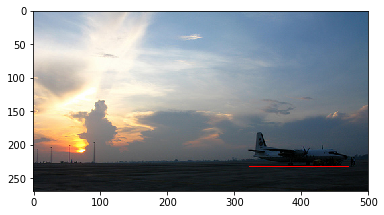

In [51]:
def PlotBox(img, box, color):
    #img = Image.open(img)
    box = (box[0], box[1], box[2], box[3])
    draw = ImageDraw.Draw(img)
    #plt.imshow(img_e)
    draw.rectangle(box, outline = color)  
    #draw.rectangle((0,0, box[2], box[3]), outline = 'red')  
    plt.imshow(img)
    plt.show()

img, pack, fn = next(iter(test_batch))
num = int(pack.size(1) / 5)
ground_truth = torch.FloatTensor(num, 4)
cls = torch.LongTensor(num)
pack = pack.squeeze(0)
#-----record the gt and cls------#
for j in xrange(num):
    ground_truth[j] = pack[5*j: 5*j+4].clone()
    cls[j] = pack[5*j+4]
while cls[0] != class_object:
    img, pack, fn = next(iter(img_batch))
    num = int(pack.size(1) / 5)  
    ground_truth = torch.FloatTensor(num, 4)
    cls = torch.LongTensor(num)
    pack = pack.squeeze(0)
    for j in xrange(num):
        ground_truth[j] = pack[5*j: 5*j+4].clone()
        cls[j] = pack[5*j+4]
    #print cls
print cls
img_e = Image.open(img_dir + '/' + fn[0])
for j in xrange(num):
    PlotBox(img_e, ground_truth[j], 'red')

4
5


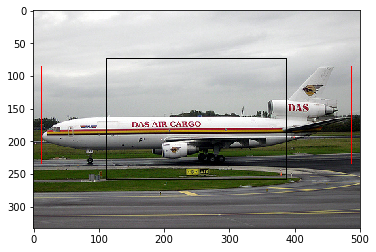

In [44]:
#----parameters initializing-----------#
#model = torch.load('newmodel4.pth')
masked = None
terminal = 0.
available_ob = np.ones(num)
feature = Extractor.forward(Variable(img).cuda())
for j in xrange(num):
    if cls[j] == class_object:
        Step = 0
        history_vector = np.zeros((num_his, action_dim))               
        box_ = torch.FloatTensor([0, 0, img.size(3), img.size(2)]) #Initial box_
        s = GetState(box_, history_vector, img)
        record = np.zeros(num)
        Trigger = None
        #box_1 = Projection(box_.squeeze(0), img)
        iou, new_iou, record, ind = IoUList(box_, ground_truth, record, available_ob, cls, class_object)
        learn_step = 0
        while(Trigger is None and Step < max_step and terminal == 0.):

            output = model.forward(s.cuda())
            action = torch.max(output.data, 1)[1].cpu().numpy()[0]
            #-------------#sample the action------#
            print action
            box, Trigger, masked = Generate(action, box_.squeeze(0))
            s2, r, img, terminal, available_ob, record, history_vector, Step = Sample(box.squeeze(0), \
                                                                img, Trigger, \
                                                        masked, action, history_vector, record, Step)
            #-------update state and box---#
            box_ = box.clone()
            s = s2
        available_ob[ind] = 0
        PlotBox(img_e, box.squeeze(0),'black')
        

In [29]:
deltas = reg.forward(roi_pooling(feature).view(-1))
print deltas.data.cpu().numpy()
bbox_pred = bbox_transform_inv(box.squeeze(0), deltas)
print Projection(bbox_pred, img), img.size(), Projection(box.squeeze(0), img)

[ 117.27700806    9.85013103  -28.30081177  -41.64170074]

   0
   0
 500
 332
[torch.FloatTensor of size 4]
 torch.Size([1, 3, 332, 500]) 
   0
   0
 500
 332
[torch.FloatTensor of size 4]



In [22]:
print bbox_pred, box
print Projection(bbox_pred, img), img.size(), Projection(box.squeeze(0), img)

NameError: name 'bbox_pred' is not defined

In [8]:
#---------record accuracy---------#
mean = np.zeros((5))
for i in range(1, 6):
    model = torch.load('resmodel' + str(i) + '.pth')
    iou_his = []
    for step, (img, pack, fn) in enumerate(test_batch):
        num = int(pack.size(1) / 5)
        #----parameters initializing-----------#
        masked = None
        terminal = None
        available_ob = np.ones(num)
        ground_truth = torch.FloatTensor(num, 4)
        cls = torch.LongTensor(num)
        pack = pack.squeeze(0)
        im_shape = np.array([img.size(3), img.size(2)])
        feature = Extractor.forward(Variable(img).cuda())
        #-----record the gt and cls------#
        for j in xrange(num):
            ground_truth[j] = pack[5*j: 5*j+4].clone()
            cls[j] = pack[5*j+4]
        #--------for every object---------#
        for j in xrange(num):
            if cls[j] == class_object:
                Step = 0
                history_vector = np.zeros((num_his, action_dim))               
                box_ = torch.FloatTensor([0, 0, feature.size(3), img.size(2)]) #Initial box_
                s = GetState(box_, history_vector, img)
                record = np.zeros(num)
                Trigger = None
                #box_1 = Projection(box_.squeeze(0), img)
                iou, new_iou, record, ind = IoUList(box_, ground_truth, record, available_ob, cls, class_object)
                while(Trigger is None and Step < max_step and terminal is None):
                    #-----get action------#
                    output = model.forward(s)
                    action = torch.max(output.data, 1)[1].cpu().numpy()[0]
                    #-------------#sample the action------#
                    box, Trigger, masked = Generate(action, box_.squeeze(0))
                    s2, r, img, terminal, available_ob, record, history_vector, Step = Sample(box.squeeze(0), \
                                                                        img, Trigger, \
                                                                masked, action, history_vector, record, Step)
                    box_ = box.clone()
                    s = s2
                available_ob[ind] = 0
                iou_his.append(record[j])
                break
                #img_e = Image.open(img_dir + '/' + fn[0])
                #PlotBox(img_e, ground_truth[j],'red')
                #PlotBox(img_e, Projection(box.squeeze(0), img),'black')
    mean[i - 1] = np.mean(iou_his)

IOError: [Errno 2] No such file or directory: 'resmodel5.pth'

[ 0.4012714   0.41096976  0.4070597   0.40916209  0.        ]


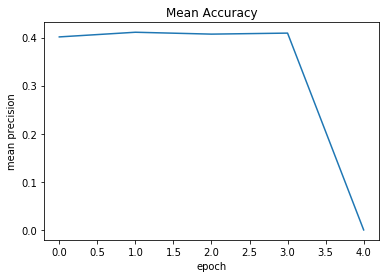

In [9]:
print mean
plt.plot(mean)
plt.xlabel('epoch')
plt.ylabel('mean precision')
plt.title('Mean Accuracy')
plt.show()

In [12]:
from sklearn.metrics import average_precision_score
def compute_mAP(labels,outputs):
    y_true = labels.cpu().numpy()
    y_pred = outputs.cpu().numpy()
    AP = []
    for i in range(y_true.shape[0]):
        AP.append(average_precision_score(y_true[i],y_pred[i]))
    return np.mean(AP)

#-------------test--------------#
net = torch.load('newmodel4.pth').cuda()

import tqdm
def evaluate(model, data_loader):
    mAP = []
    model.eval()
    for i, (images, labels) in tqdm.tqdm(enumerate(data_loader),
                                               total=Dataset_length,
                                               ncols=80, leave=False):
        images = images.view((-1,3,images.size(3),images.size(4)))
        images = Variable(images, volatile=True).cuda()
        # Forward + Backward + Optimize
        outputs = net(images)
        outputs = outputs.cpu().data
        outputs = outputs.view((-1, 10, 21))
        outputs = outputs.mean(dim=1).view((-1,21))

        #score = tnt.meter.mAPMeter(outputs, labels)
        mAP.append(compute_mAP(labels,outputs))
    return mAP
Dataset_length = len(val_loader)
#net = torch.load('roi_net40.pth')
score = evaluate(net, val_loader)

print('mAP:{}'.format(100*np.mean(score)))  #roi_class_net1.pth: mAP:44.7912577695

0.296615299198


In [38]:
anchors = generate_anchors(box.squeeze(0).numpy())
anchors = check_anchors(anchors, im_shape)
num_anchors = anchors.shape[0]
p = np.zeros((num_anchors, num))
for k in xrange(num_anchors):
    for j in xrange(num):
        p[k][j] = IoU(torch.from_numpy(anchors[k]).long(), ground_truth[j])
arg = np.argmax(p)
PlotBox(img_e, anchors[arg], 'green')

NameError: name 'generate_anchors' is not defined


 1
[torch.LongTensor of size 1]



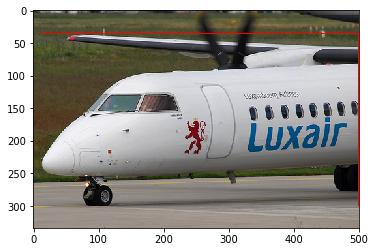

In [30]:
img, pack, fn = next(iter(test_batch))
num = int(pack.size(1) / 5)
ground_truth = torch.FloatTensor(num, 4)
cls = torch.LongTensor(num)
pack = pack.squeeze(0)
#-----record the gt and cls------#
for j in xrange(num):
    ground_truth[j] = pack[5*j: 5*j+4].clone()
    cls[j] = pack[5*j+4]
while cls[0] != class_object:
    img, pack, fn = next(iter(img_batch))
    num = int(pack.size(1) / 5)  
    ground_truth = torch.FloatTensor(num, 4)
    cls = torch.LongTensor(num)
    pack = pack.squeeze(0)
    for j in xrange(num):
        ground_truth[j] = pack[5*j: 5*j+4].clone()
        cls[j] = pack[5*j+4]
    #print cls
print cls
img_e = Image.open(img_dir + '/' + fn[0])
for j in xrange(num):
    PlotBox(img_e, ground_truth[j], 'red')

In [31]:
for j in xrange(num):
    if cls[j] == class_object:
        Step = 0
        history_vector = np.zeros((num_his, action_dim))               
        box_ = torch.LongTensor([0, 0, img.size(3), img.size(2)]) #Initial box_
        s = GetState(box_, history_vector)
        record = np.zeros(num)
        Trigger = None
        iou, new_iou, record, ind = IoUList(box_, ground_truth, record, available_ob, cls, class_object)
        print box_
        PlotBox(img_e, box_)
        learn_step = 0
        while(Trigger is None and Step < max_step and terminal is None):
            output = model.forward(s.cuda())
            action = torch.max(output.data, 1)[1].cpu().numpy()[0]
            print action
            #-------------#sample the action------#
            box, Trigger, masked = Generate(action, box_.squeeze(0) , img)
            print box
            s2, r, img, terminal, available_ob, record, history_vector, Step = Sample(box.squeeze(0), \
                                                                img, Trigger, \
                                                        masked, action, history_vector, record, Step)
            PlotBox(img_e, box.squeeze(0))
            box_ = box.clone()
            s = s2
        available_ob[ind] = 0

RuntimeError: can't assign a numpy.float64 to a scalar value of type int

In [59]:
                        target_a = actor_target.forward(s2_batch).detach()
                        target_q = torch.squeeze(critic_target.forward(s2_batch, target_a).detach())
                        y_expected = r_batch + gamma * target_q
                        y_predicted = torch.squeeze(critic.forward(s_batch, a_batch))

                        optimizer_c.zero_grad()
                        optimizer_a.zero_grad()

                        loss_ = loss_func(y_predicted, y_expected)
                        loss_.backward(retain_variables = True)
                        torch.nn.utils.clip_grad_norm(actor.parameters(), 50)
                        torch.nn.utils.clip_grad_norm(critic.parameters(), 50)
                        optimizer_c.step()
                        optimizer_a.step()

                        critic_target.load_state_dict(CreateDict(critic_target, critic))
                        actor_target.load_state_dict(CreateDict(actor_target, actor))
                        CheckGradientUpdate(actor_target, actor)
                        CheckGradientUpdate(critic_target, critic)


   0
   0
 375
 500
[torch.LongTensor of size 4]



In [25]:
vgg = models.vgg19(pretrained = True).features
Extractor = nn.Sequential(*list(vgg.children())[:-5])
print Extractor.forward(Variable(img)).size()

torch.Size([1, 512, 23, 31])


In [27]:
feature = Extractor.forward(Variable(img))
rpn = nn.Conv2d(512, 18, kernel_size =(1, 1), stride =(1, 1), padding = 0, bias = False)
print rpn(feature)

Variable containing:
(0 ,0 ,.,.) = 
  0.0225 -0.0670  0.1349  ...   1.2932  0.2054  0.9787
  0.3248 -0.0658 -0.3771  ...   0.4038  0.4716  0.6250
  1.0249  0.3834  0.2776  ...   0.5187  0.5418  1.0068
           ...             ⋱             ...          
  0.4081  0.3622  0.4738  ...   0.2324  0.3003  0.4066
  0.5652  0.8176  0.8932  ...  -0.1861 -0.3074  0.1726
  1.0484  0.8312  0.6352  ...   0.6594 -0.7874  0.0092

(0 ,1 ,.,.) = 
 -0.8800 -0.8769  0.1415  ...  -1.4946 -1.8461 -1.1987
  0.3194 -0.5320  0.4474  ...   0.0437 -0.0754 -0.0240
  0.2528  0.0487  0.3557  ...   0.3107  0.3399 -0.3458
           ...             ⋱             ...          
 -0.8407 -0.0101  0.1491  ...   0.1500  0.4505  0.3921
 -0.7357 -0.2333 -0.1211  ...  -0.0529 -0.2503 -0.2634
 -0.9433 -0.8932 -0.8737  ...  -0.1887 -0.0043 -0.0902

(0 ,2 ,.,.) = 
 -2.5139 -1.4810 -0.1878  ...  -0.9408 -1.8013 -1.7798
 -1.6328 -1.2597  0.0643  ...  -0.4021 -0.2795 -0.3374
 -2.1675 -1.4635 -0.4979  ...  -0.6050 -0.2912 -0.34

In [ ]:
class Translation(object):
    def __init__(self, box):
        self.width, self.height, self.center_x, self.center_y = _whctrs(box)
        self.x_step = self.width * translate
        self.y_step = self.height * translate
        self.xmin, self.ymin, self.xmax, self.ymax = box
        
    def Up(self):
        self.ymin = self.ymin - self.y_step
        self.ymax = self.ymax - self.y_step
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None
        
    def Down(self):
        self.ymin = self.ymin + self.y_step
        self.ymax = self.ymax + self.y_step
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None
    
    def Left(self):
        self.xmin = self.xmin - self.x_step
        self.xmax = self.xmax - self.x_step
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None
    
    def Right(self):
        self.xmin = self.xmin + self.x_step
        self.xmax = self.xmax + self.x_step
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None
    
    def Enlarge(self):
        self.ymin = self.ymin - self.y_step
        self.ymax = self.ymax + self.y_step
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None
    
    def Shrink(self):
        self.ymin = self.ymin + self.y_step
        self.ymax = self.ymax - self.y_step
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None
    
    def Narrow(self):
        self.xmin = self.xmin + self.x_step
        self.xmax = self.xmax - self.x_step
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None
    
    def Stretch(self):
        self.xmin = self.xmin - self.x_step
        self.xmax = self.xmax + self.x_step
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None
        

class Scaling(object):
    def __init__(self, box):
        self.xmin, self.ymin, self.xmax, self.ymax = box
        self.width, self.height, self.center_x, self.center_y = _whctrs(box)
        self.width *= scale_subregion
        self.height *= scale_subregion
        self.box = box

    def UpLeft(self):
        self.xmax = self.xmin + self.width
        self.ymax = self.ymin + self.height
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None
    
    def UpRight(self):
        self.xmin = self.xmax - self.width
        self.ymax = self.ymin + self.height
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None      
    
    def DownLeft(self):
        self.xmax = self.xmin + self.width
        self.ymin = self.ymax - self.height
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None        
    
    def DownRight(self):
        self.xmin = self.xmax - self.width
        self.ymin = self.ymax - self.height
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None       
    
    def Center(self):
        self.xmax = self.center_x + self.width / 2
        self.xmin = self.center_x - self.width / 2 
        self.ymax = self.center_y + self.height / 2
        self.ymin = self.center_y - self.height / 2
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None
    
    def Shrink(self):
        self.width /= scale_subregion
        #self.height /= scale_subregion
        self.ymin = self.center_y - self.height / 2
        self.ymax = self.center_y + self.height / 2
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None
    
    def Narrow(self):
        #self.width /= scale_subregion
        self.height /= scale_subregion
        self.xmin = self.center_x - self.width /2
        self.xmax = self.center_x + self.width /2 
        new_box = torch.FloatTensor([[self.xmin, self.ymin, self.xmax, self.ymax]])
        return new_box, None, None
    
    def Trigger(self):
        return self.box, True, True
    
def Generate(a, box):
    if a == 0:
        return Translation(box).Up()
    elif a == 1:
        return Translation(box).Down()
    elif a == 2:
        return Translation(box).Left()
    elif a == 3:
        return Translation(box).Right()
    elif a == 4:
        return Translation(box).Stretch()
    elif a == 5:
        return Translation(box).Shrink()
    elif a == 6:
        return Translation(box).Enlarge()
    elif a == 7:
        return Translation(box).Narrow()
    elif a == 8:
        return Scaling(box).UpLeft()
    elif a == 9:
        return Scaling(box).UpRight()
    elif a == 10:
        return Scaling(box).DownLeft()
    elif a == 11:
        return Scaling(box).DownRight()
    elif a == 12:
        return Scaling(box).Center()
    else:
        return Scaling(box).Trigger()
    

In [ ]:
class ClsNetwork(nn.Module):
    def __init__(self, input_dim, translation_dim, scaling_dim):
        super(QNetwork, self).__init__()
        self.model1 = torch.nn.Sequential(
               nn.Linear(input_dim, 1024), nn.ReLU(), nn.Dropout(p=0.2),
               nn.Linear(1024, 1024), nn.ReLU(), nn.Dropout(p=0.2),
               nn.Linear(1024, translation_dim),
        )
        self.model2 = torch.nn.Sequential(
               nn.Linear(input_dim, 1024), nn.ReLU(), nn.Dropout(p=0.2),
               nn.Linear(1024, 1024), nn.ReLU(), nn.Dropout(p=0.2),
               nn.Linear(1024, scaling_dim),
        )

    def forward(self, x):
        out1 = self.model1(x)
        out2 = self.model2(x)
        return out1, out2

In [5]:
def generate_anchors(base_anchor, ratios=[0.5, 1, 2],
                     scales=2**np.arange(0, 3)):
    ratio_anchors = _ratio_enum(base_anchor, ratios)
    anchors = np.vstack([_scale_enum(ratio_anchors[i, :], scales)
                         for i in xrange(ratio_anchors.shape[0])])
    return anchors



def _ratio_enum(anchor, ratios):
    w, h, x_ctr, y_ctr = _whctrs(anchor)
    size = w * h
    size_ratios = size / ratios
    ws = np.round(np.sqrt(size_ratios))
    hs = np.round(ws * ratios)
    #print ws, hs
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

def _scale_enum(anchor, scales):
    w, h, x_ctr, y_ctr = _whctrs(anchor)
    ws = w * scales
    hs = h * scales
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

def check_anchors(anchors, im_shape):
    allowed_border = 0
    inds_inside = np.where(
    (anchors[:, 0] >= -allowed_border) &
    (anchors[:, 1] >= -allowed_border) &
    (anchors[:, 2] < im_shape[0] + allowed_border) &  # width
    (anchors[:, 3] < im_shape[1] + allowed_border)    # height
    )[0]
    anchors = anchors[inds_inside, :]
    return anchors

In [11]:
#-------calculate top k errors-----------------#
#model = torch.load('roi_net.pth').cuda()
import tqdm
def evaluate(model, data_loader):
    score = []
    model.eval()
    total = 0
    correct = 0
    for i, (img, pack, label,  fn) in tqdm.tqdm(enumerate(data_loader),
                                               total=Dataset_length,
                                               ncols=80, leave=False):
        num = int(pack.size(1) / 5)
        cls = torch.LongTensor(num)
        pack = pack.squeeze(0)
        for j in xrange(num):
            cls[j] = pack[5*j+4]
            
        #label = Variable(torch.LongTensor([cls[j]])).cuda()

        output = model(Variable(img).cuda())
        _, pred = output.topk(num, 1, True, True)
        total += num
        correct += (pred.data.cpu() == cls).sum()   
        if i % 100 == 0:
            score.append(float(correct)/total)
        #score = torch.nn.functional.upsample_bilinear(score, (1280, 1918))
    return score
Dataset_length = len(test_data)
#model = torch.load('vgg_roi_class_net.pth')
score = evaluate(net, test_batch)


  5%|█▊                                      | 263/5823 [00:04<01:32, 60.23it/s]
                                                                                
 22%|████████▍                              | 1265/5823 [00:21<01:17, 58.50it/s]


 34%|█████████████                          | 1953/5823 [00:32<01:03, 60.51it/s]

RuntimeError: invalid argument 5: k not in range for dimension at /pytorch/torch/lib/THC/generic/THCTensorTopK.cu:21


 34%|█████████████                          | 1953/5823 [00:44<01:28, 43.63it/s]